c:\Users\brigh\Documents\GitHub\warehouse\.venv\Lib\site-packages\seaborn\_statistics.py:32: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.3.3)
  from scipy.stats import gaussian_kde


[Layer 0] 데이터 로드 완료
[Layer 1] 교과목 태깅 및 학과 DNA 정의 완료
[Layer 2] Z-Score 및 흥미 점수 산출 완료
[Layer 3] 인재 발굴 완료: 총 36명 식별됨


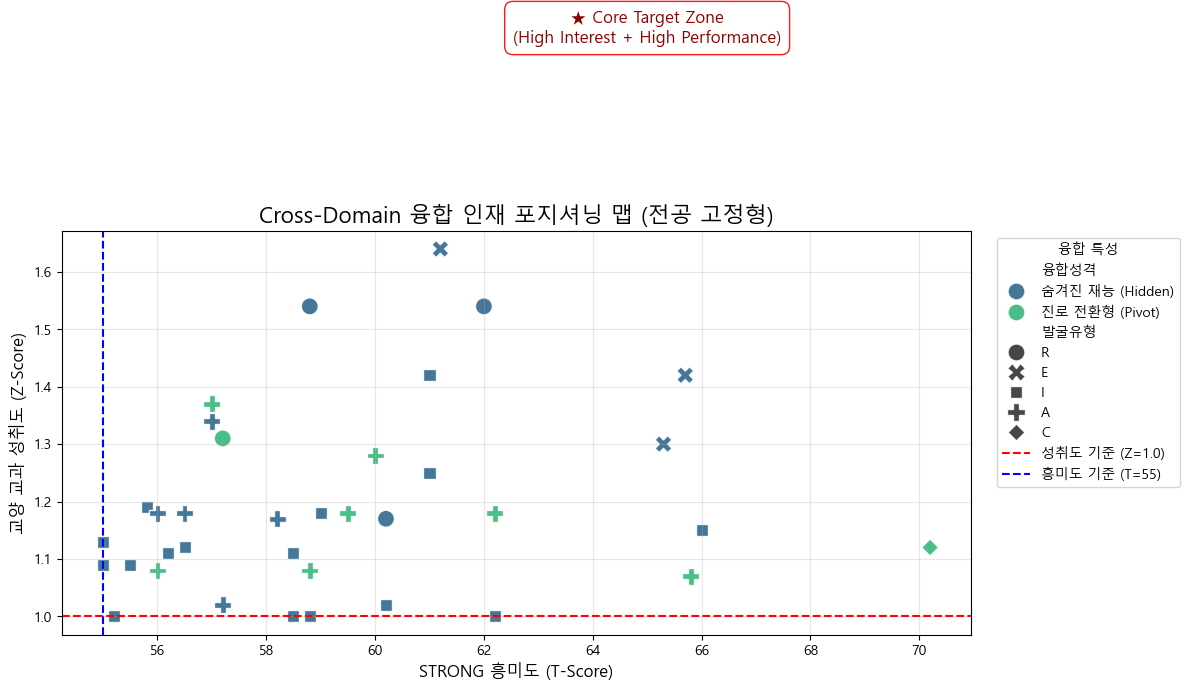


=== [Result] 최종 발굴된 융합 인재 리스트 (Top 10) ===
       학번        학과 전공유형 발굴유형            융합성격  성취도(Z)  흥미도
05462F6C3   중등특수교육과    S    E 숨겨진 재능 (Hidden)    1.64 61.2
05449F8E6    한국어문학과    A    R 숨겨진 재능 (Hidden)    1.54 58.8
0547EF1AD 웹툰만화콘텐츠학과    A    R 숨겨진 재능 (Hidden)    1.54 62.0
05471CFED     기계공학과    R    E 숨겨진 재능 (Hidden)    1.42 65.7
0547F1BDE    물류무역학과    A    I 숨겨진 재능 (Hidden)    1.42 61.0
0547EE065      경영학과    C    A  진로 전환형 (Pivot)    1.37 57.0
0547EF02C      경영학과    C    A 숨겨진 재능 (Hidden)    1.34 57.0
0547EE17D  일본언어문화학과    A    R  진로 전환형 (Pivot)    1.31 57.2
0546CCAD3     국어교육과    S    E 숨겨진 재능 (Hidden)    1.30 65.3
0547ED7B3    인공지능학과    R    A  진로 전환형 (Pivot)    1.28 60.0


In [1]:
'''
[Cross-Domain 융합 인재 발굴 프로젝트 End-to-End 코드]

이 코드는 다음 4단계 레이어를 통해 '숨겨진 융합 인재'를 발굴합니다.

Layer 1. [Data Engineering] 데이터 표준화 및 태깅 (Tagging)
    - 교과목 분류: STRONG 표준 키워드 기반으로 과목 성격(RIASEC) 정의
    - 학과 DNA 정의: 재학생 STRONG 데이터 최빈값을 기준으로 학과 성향 정의

Layer 2. [Metric Calculation] 상대적 우수성 지표 산출 (Scoring)
    - 성적 거품 제거: 과목별 난이도를 고려한 Z-Score(표준점수) 산출
    - 흥미 척도 계산: BIS(하위척도) 점수 평균화

Layer 3. [Talent Scouting] 융합 인재 필터링 (Filtering)
    - Cross-Domain 탐색: 전공(Base)과 다른 영역(Target) 탐색
    - 검증 필터: 흥미(T>=55) & 실력(Z>=1.0) 동시 만족 조건 적용

Layer 4. [Insight Visualization] 결과 시각화 및 리포팅
    - 4사분면 매트릭스: 전체 학생 중 융합 인재의 희소성 시각화
'''

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정 (실행 환경에 따라 폰트 경로 수정 필요, 여기선 기본 설정)
plt.rcParams['font.family'] = 'Malgun Gothic' 
plt.rcParams['axes.unicode_minus'] = False

# =============================================================================
# Layer 0. 데이터 로드 (Data Loading)
# =============================================================================
try:
    course_list_df = pd.read_excel('교양교과목록_최종.xlsx')
    course_history_df = pd.read_excel('교양교과_수강정보_최종.xlsx')
    strong_df = pd.read_excel('STRONG_최종.xlsx')
    print("[Layer 0] 데이터 로드 완료")
except Exception as e:
    print(f"[Error] 데이터 로드 실패: {e}")


# =============================================================================
# Layer 1. [Data Engineering] 데이터 표준화 및 태깅
# =============================================================================

# 1-1. 교과목 분류 (STRONG 표준 키워드 매핑)
manual_mapping = {
    '맛있는중국,멋있는중국': 'A', '에디톨로지인간의삶': 'I', '한끼의권리': 'S', 
    '적성이이끄는삶': 'I', '정의란무엇인가': 'I', '삶과드라마': 'A', '여가': 'A'
}

strong_keywords_code = {
    'R': ['골프', '축구', '풋살', '스킨스쿠버', '태권도', '탁구', '테니스', '댄스', '호신술', 
          '건강', '재해', '안전', '환경', '생태', '자동차', '드론', '메이커', '3D', '기계', 
          '스포츠', '신체', '농업', '배드민턴', '농생명', '탄소', '에너지', '우주', '지구', 
          '한옥', '군사', '안보', '전투', '지휘', '야전'],
    'I': ['4차산업', 'AI', '인공지능', '데이터', '통계', '수학', '뇌과학', '역사', '철학', 
          '사상', '비판적사고', '인문', '지역학', '과학', '탐구', '논리', '물리', '화학', 
          '생물', '이해', '소프트웨어', 'SW', '코딩', '컴퓨팅', '컴퓨터', '알고리즘', 
          'ChatGPT', '개발자', '고전', '인간', '지성', '공존', '인구', '유전', '한의학', 
          '한국사', '지리학', '세계대전', '사고와'],
    'A': ['디자인', '미술', '음악', '영화', '연극', '사진', '글쓰기', '문학', '스토리', 
          '한국어', '영어', '중국어', '일본어', '회화', '예술', '창작', '언어', '표현', 
          '드로잉', '영상', '문화', '한자', '오페라', '한문', '잉글리시', 'English', 
          '콘텐츠', '시나리오', '서사', '패션', '와인', '작문'],
    'S': ['봉사', '멘토링', '인권', '복지', '나눔', '심리', '교육', '코칭', '부모', 
          '기독교', '채플', '행복', '성경', '상담', 'AHA', '보살핌', '웰빙', '갈등', 
          '치유', '놀이'],
    'E': ['창업', '스타트업', '경영', '마케팅', '기획', '리더십', '법', '토론', '스피치', 
          '발표', '협상', '권력', '비즈니스', '경제', 'CEO', '리더', '진로', '행정', 
          '범죄', '직무', '커리어', '기업', 'NCS', '취업', '프리젠테이션', '화술', '정치'],
    'C': ['엑셀', 'PPT', '문서', '회계', '세무', '재테크', '투자', '금융', '자산', '실무', 
          '컴퓨터활용', '정보', '스마트', '부동산', '원가', '보고서', '파워포인트', '신용', 
          '채권', '보험']
}

def classify_course_code(course_name):
    if pd.isna(course_name): return 'Unclassified'
    course_str = str(course_name).replace(" ", "")
    
    # 1순위: 수동 매핑
    if course_name in manual_mapping: return manual_mapping[course_name]
    
    # 2순위: 키워드 매칭
    for code, keywords in strong_keywords_code.items():
        for keyword in keywords:
            if keyword in course_str: return code
            
    return 'Unclassified'

course_list_df['Course_Type'] = course_list_df['교과목명'].apply(classify_course_code)


# 1-2. STRONG 데이터 정제 (컬럼명 복구)
new_columns = list(strong_df.columns)
bis_names = strong_df.iloc[1, 7:37].tolist() # 하위척도 이름 추출
for i, name in enumerate(bis_names): new_columns[7 + i] = name

strong_clean = strong_df.iloc[2:].copy()
strong_clean.columns = new_columns
strong_clean = strong_clean.reset_index(drop=True)

# 분석용 데이터 추출 (학번, 학과, 흥미유형, BIS점수)
target_cols = ['학번', '학부(과)', 'GOT 흥미유형'] + bis_names
strong_user = strong_clean[target_cols].copy()


# 1-3. 학과 DNA 정의 (데이터 기반 학과 성향 도출)
# GOT 1순위 코드 추출 함수
def extract_got_codes_list(val):
    if pd.isna(val): return []
    codes = []
    parts = str(val).split(',')
    for part in parts:
        part = part.strip()
        if '(' in part:
            code = part.split('(')[1].replace(')', '')
        else:
            code = part[0]
        codes.append(code)
    return codes

strong_user['GOT_List'] = strong_user['GOT 흥미유형'].apply(extract_got_codes_list)
strong_user['GOT_Main'] = strong_user['GOT_List'].apply(lambda x: x[0] if len(x) > 0 else np.nan)

# 학과별 최빈값(Mode) 산출 -> 해당 학과의 Dominant Type 정의
dept_dna = strong_user.groupby('학부(과)')['GOT_Main'].agg(
    lambda x: x.mode()[0] if not x.mode().empty else np.nan
).reset_index()
dept_dna.columns = ['학부(과)', 'Dept_Dominant_Type']

# 학생 데이터에 학과 DNA 병합
strong_user = pd.merge(strong_user, dept_dna, on='학부(과)', how='left')
print("[Layer 1] 교과목 태깅 및 학과 DNA 정의 완료")


# =============================================================================
# Layer 2. [Metric Calculation] 상대적 우수성 지표 산출
# =============================================================================

# 2-1. 성적 거품 제거 (Z-Score 산출)
# 수강기록 + 과목타입 병합
history_merged = pd.merge(course_history_df, course_list_df[['교과목명', 'Course_Type']], 
                          left_on='과목명', right_on='교과목명', how='left')

# 유효 데이터 필터링 (미분류 제외, 점수 있는 것만)
history_valid = history_merged[
    (history_merged['Course_Type'] != 'Unclassified') & 
    (pd.to_numeric(history_merged['취득점수'], errors='coerce').notnull())
].copy()
history_valid['취득점수'] = history_valid['취득점수'].astype(float)

# 과목별 평균/표준편차 계산 -> Z-Score 산출
course_stats = history_valid.groupby('과목명')['취득점수'].agg(['mean', 'std']).reset_index()
history_valid = pd.merge(history_valid, course_stats, on='과목명', how='left')
history_valid['z_score'] = (history_valid['취득점수'] - history_valid['mean']) / history_valid['std']
history_valid['z_score'] = history_valid['z_score'].fillna(0) # 표준편차 0인 경우 0 처리

# 학생별 유형별 평균 성취도 집계
student_course_perf = history_valid.groupby(['학번', 'Course_Type'])['z_score'].mean().unstack(fill_value=-999).reset_index()


# 2-2. BIS 점수 집계 (6대 유형별 평균 흥미도 산출)
master_df = pd.merge(strong_user, student_course_perf, on='학번', how='inner')

bis_map = {
    'R': ['기계/건설', '컴퓨터/전자기기', '군사활동', '안전서비스', '자연/농업', '운동경기'],
    'I': ['과학', '연구조사', '의학', '수학'],
    'A': ['시각예술', '공연예술', '글쓰기/언론', '요리'],
    'S': ['상담/봉사', '교육', '인적 자원개발', '사회봉사', '종교/영성', '보건의료'],
    'E': ['마케팅/광고', '판매', '관리', '기업운영', '정치/대중연설', '법'],
    'C': ['사무관리', '세무/회계', '정보시스템', '금융/투자']
}

for code, cols in bis_map.items():
    valid_cols = [c for c in cols if c in strong_user.columns]
    if valid_cols:
        for c in valid_cols: master_df[c] = pd.to_numeric(master_df[c], errors='coerce')
        master_df[f'Interest_{code}'] = master_df[valid_cols].mean(axis=1)

print("[Layer 2] Z-Score 및 흥미 점수 산출 완료")


# =============================================================================
# Layer 3. [Talent Scouting] 융합 인재 필터링 (The Funnel)
# =============================================================================

results = []
types = ['R', 'I', 'A', 'S', 'E', 'C']

for idx, row in master_df.iterrows():
    dept_type = row['Dept_Dominant_Type'] # 학생의 전공 유형 (Base)
    got_list = row['GOT_List']            # 학생의 흥미 순위 (1~3위)
    
    for talent_type in types:
        
        # [Filter 1] Cross-Domain Check
        # 전공 적합형(Specialist)은 제외하고, 이질적인 유형만 탐색
        if talent_type == dept_type: continue
        
        # [Filter 2] 데이터 존재 여부 확인
        if talent_type in student_course_perf.columns:
            z_val = row[talent_type]
            interest_val = row.get(f'Interest_{talent_type}', 0)
            
            # [Filter 3] High Potential Check (엄격한 기준 적용)
            # 실력: Z-Score >= 1.0 (상위 약 15%)
            # 흥미: T-Score >= 55 (평균 50점 상회)
            if z_val >= 1.0 and interest_val >= 55:
                
                # 융합 성격 규명 (Insight Tagging)
                fusion_category = ""
                rank = -1
                
                if talent_type in got_list:
                    rank = got_list.index(talent_type) + 1
                    if rank == 1:
                        # 전공과 맞지 않는데(Step 1), 이 분야가 1순위 흥미다 -> Pivot
                        fusion_category = "진로 전환형 (Pivot)"
                    else:
                        # 전공도 하면서(가정), 이 분야도 2~3순위로 좋아한다 -> Expansion
                        fusion_category = "역량 확장형 (Expansion)"
                else:
                    # 흥미 TOP3엔 없는데 점수는 높음 -> Hidden
                    fusion_category = "숨겨진 재능 (Hidden)"
                    rank = 99
                
                results.append({
                    '학번': row['학번'],
                    '학과': row['학부(과)'],
                    '전공유형': dept_type,
                    '발굴유형': talent_type,
                    '융합성격': fusion_category,
                    '흥미순위': rank if rank != 99 else '순위외',
                    '성취도(Z)': round(z_val, 2),
                    '흥미도': round(interest_val, 1)
                })

result_df = pd.DataFrame(results)
print(f"[Layer 3] 인재 발굴 완료: 총 {len(result_df)}명 식별됨")


# =============================================================================
# Layer 4. [Insight Visualization] 4사분면 매트릭스 시각화
# =============================================================================

if not result_df.empty:
    plt.figure(figsize=(12, 8))
    
    # 1사분면(Target) 강조를 위한 산점도
    # hue: 융합 성격(Pivot/Expansion/Hidden), style: 발굴 유형(R/I/A...)
    sns.scatterplot(data=result_df, x='흥미도', y='성취도(Z)', 
                    hue='융합성격', style='발굴유형', s=150, alpha=0.9, palette='viridis')
    
    # 기준선 (Thresholds) - 분석의 엄격함 증명
    plt.axhline(1.0, color='red', linestyle='--', linewidth=1.5, label='성취도 기준 (Z=1.0)')
    plt.axvline(55, color='blue', linestyle='--', linewidth=1.5, label='흥미도 기준 (T=55)')
    
    # 영역 설명 (Target Zone)
    plt.text(65, 2.0, '★ Core Target Zone\n(High Interest + High Performance)', 
             fontsize=12, color='darkred', ha='center', 
             bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.5', alpha=0.9))
    
    plt.title('Cross-Domain 융합 인재 포지셔닝 맵 (전공 고정형)', fontsize=16)
    plt.xlabel('STRONG 흥미도 (T-Score)', fontsize=12)
    plt.ylabel('교양 교과 성취도 (Z-Score)', fontsize=12)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', title='융합 특성')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 요약 리스트 출력
    print("\n=== [Result] 최종 발굴된 융합 인재 리스트 (Top 10) ===")
    print(result_df[['학번', '학과', '전공유형', '발굴유형', '융합성격', '성취도(Z)', '흥미도']]
          .sort_values(by='성취도(Z)', ascending=False).head(10).to_string(index=False))
else:
    print("조건을 만족하는 융합 인재가 발견되지 않았습니다.")

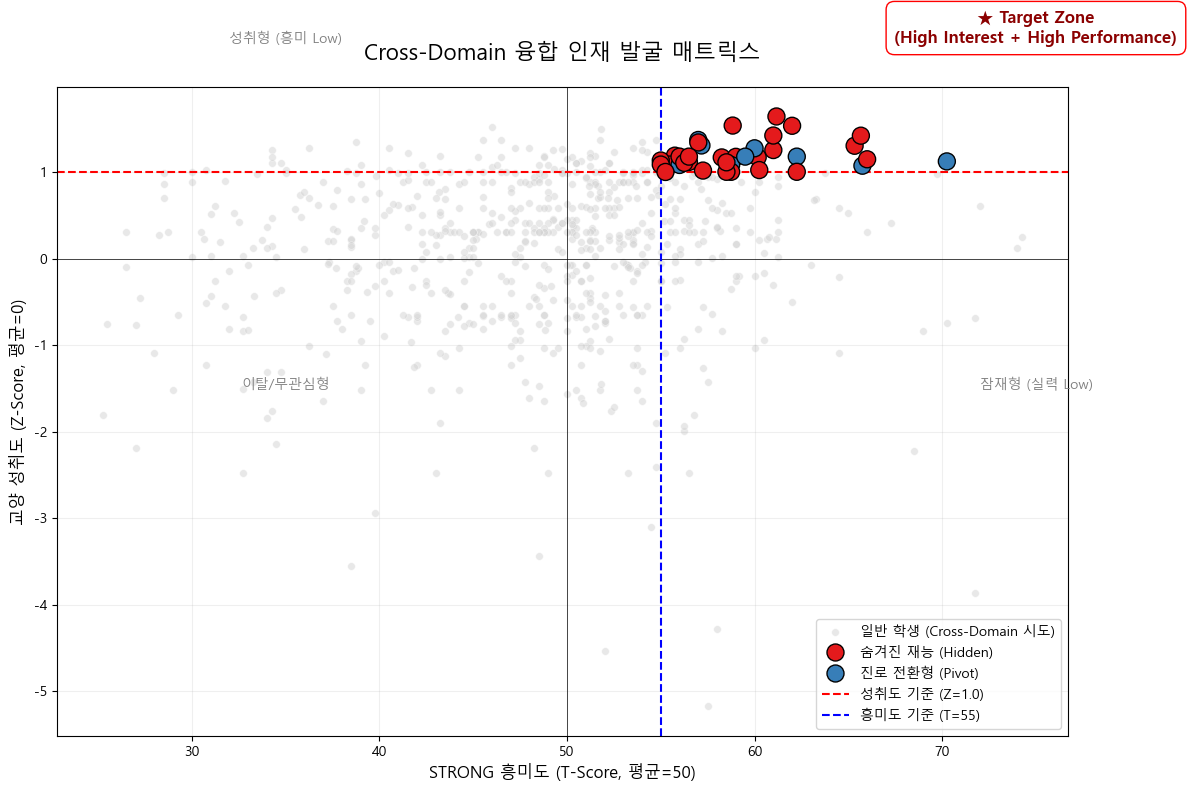


 [Final Report] 데이터가 찾아낸 'Cross-Domain' 융합 인재 리스트
 ※ 용어 설명
  - 융합성격:
    1) 진로 전환형 (Pivot): 전공과 맞지 않으나(1순위X), 해당 분야가 1순위 흥미인 학생
    2) 역량 확장형 (Expansion): 전공도 맞고(1순위), 해당 분야도 2~3순위로 좋아하는 학생
    3) 숨겨진 재능 (Hidden): 흥미 순위권 밖이지만, 세부 척도(BIS) 점수가 높은 잠재적 인재
  - 흥미도: T-Score (평균 50, 표준편차 10). 55점 이상이면 '명확한 선호' 의미
--------------------------------------------------------------------------------
       학번        학과    전공유형    발굴유형            융합성격  성취도(Z)  흥미도
05462F6C3   중등특수교육과 S (사회형) E (진취형) 숨겨진 재능 (Hidden)    1.64 61.2
0547EF1AD 웹툰만화콘텐츠학과 A (예술형) R (현장형) 숨겨진 재능 (Hidden)    1.54 62.0
05449F8E6    한국어문학과 A (예술형) R (현장형) 숨겨진 재능 (Hidden)    1.54 58.8
05471CFED     기계공학과 R (현장형) E (진취형) 숨겨진 재능 (Hidden)    1.42 65.7
0547F1BDE    물류무역학과 A (예술형) I (탐구형) 숨겨진 재능 (Hidden)    1.42 61.0
0547EE065      경영학과 C (사무형) A (예술형)  진로 전환형 (Pivot)    1.37 57.0
0547EF02C      경영학과 C (사무형) A (예술형) 숨겨진 재능 (Hidden)    1.34 57.0
0547EE17D  일본언어문화학과 A (예술형) R (현장형)  진로 전환형 (Pivot)    1.31 57.2
0546CCAD3     국어교육과 S (사회

In [2]:
'''
[Cross-Domain 융합 인재 발굴 최종 분석 코드]

1. 시각화 전략: 전체 모집단(Grey) vs 발굴된 인재(Color) 대비 효과
2. 결과 리스트: 유형 명칭 구체화 및 상세 설명 추가
'''

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic' 
plt.rcParams['axes.unicode_minus'] = False

# =============================================================================
# [Step 1] 데이터 로드 및 전처리 (이전과 동일)
# =============================================================================
course_list_df = pd.read_excel('교양교과목록_최종.xlsx')
course_history_df = pd.read_excel('교양교과_수강정보_최종.xlsx')
strong_df = pd.read_excel('STRONG_최종.xlsx')

# 1. 교과목 분류
manual_mapping = {'맛있는중국,멋있는중국': 'A', '에디톨로지인간의삶': 'I', '한끼의권리': 'S', '적성이이끄는삶': 'I', '정의란무엇인가': 'I', '삶과드라마': 'A', '여가': 'A'}
strong_keywords_code = {
    'R': ['골프', '축구', '풋살', '스킨스쿠버', '태권도', '탁구', '테니스', '댄스', '호신술', '건강', '재해', '안전', '환경', '생태', '자동차', '드론', '메이커', '3D', '기계', '스포츠', '신체', '농업', '배드민턴', '농생명', '탄소', '에너지', '우주', '지구', '한옥', '군사', '안보', '전투', '지휘', '야전'],
    'I': ['4차산업', 'AI', '인공지능', '데이터', '통계', '수학', '뇌과학', '역사', '철학', '사상', '비판적사고', '인문', '지역학', '과학', '탐구', '논리', '물리', '화학', '생물', '이해', '소프트웨어', 'SW', '코딩', '컴퓨팅', '컴퓨터', '알고리즘', 'ChatGPT', '개발자', '고전', '인간', '지성', '공존', '인구', '유전', '한의학', '한국사', '지리학', '세계대전', '사고와'],
    'A': ['디자인', '미술', '음악', '영화', '연극', '사진', '글쓰기', '문학', '스토리', '한국어', '영어', '중국어', '일본어', '회화', '예술', '창작', '언어', '표현', '드로잉', '영상', '문화', '한자', '오페라', '한문', '잉글리시', 'English', '콘텐츠', '시나리오', '서사', '패션', '와인', '작문'],
    'S': ['봉사', '멘토링', '인권', '복지', '나눔', '심리', '교육', '코칭', '부모', '기독교', '채플', '행복', '성경', '상담', 'AHA', '보살핌', '웰빙', '갈등', '치유', '놀이'],
    'E': ['창업', '스타트업', '경영', '마케팅', '기획', '리더십', '법', '토론', '스피치', '발표', '협상', '권력', '비즈니스', '경제', 'CEO', '리더', '진로', '행정', '범죄', '직무', '커리어', '기업', 'NCS', '취업', '프리젠테이션', '화술', '정치'],
    'C': ['엑셀', 'PPT', '문서', '회계', '세무', '재테크', '투자', '금융', '자산', '실무', '컴퓨터활용', '정보', '스마트', '부동산', '원가', '보고서', '파워포인트', '신용', '채권', '보험']
}
def classify_course_code(course_name):
    if pd.isna(course_name): return 'Unclassified'
    course_str = str(course_name).replace(" ", "")
    if course_name in manual_mapping: return manual_mapping[course_name]
    for code, keywords in strong_keywords_code.items():
        for keyword in keywords:
            if keyword in course_str: return code
    return 'Unclassified'
course_list_df['Course_Type'] = course_list_df['교과목명'].apply(classify_course_code)

# 2. STRONG 데이터 전처리
new_columns = list(strong_df.columns)
bis_names = strong_df.iloc[1, 7:37].tolist()
for i, name in enumerate(bis_names): new_columns[7 + i] = name
strong_clean = strong_df.iloc[2:].copy()
strong_clean.columns = new_columns
target_cols = ['학번', '학부(과)', 'GOT 흥미유형'] + bis_names
strong_user = strong_clean[target_cols].copy()

def extract_got_codes_list(val):
    if pd.isna(val): return []
    codes = []
    parts = str(val).split(',')
    for part in parts:
        part = part.strip()
        if '(' in part: code = part.split('(')[1].replace(')', '')
        else: code = part[0]
        codes.append(code)
    return codes
strong_user['GOT_List'] = strong_user['GOT 흥미유형'].apply(extract_got_codes_list)
strong_user['GOT_Main'] = strong_user['GOT_List'].apply(lambda x: x[0] if len(x) > 0 else np.nan)

# 학과 DNA 정의
dept_dna = strong_user.groupby('학부(과)')['GOT_Main'].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan).reset_index()
dept_dna.columns = ['학부(과)', 'Dept_Dominant_Type']
strong_user = pd.merge(strong_user, dept_dna, on='학부(과)', how='left')

# 3. 성적 Z-Score 산출
history_merged = pd.merge(course_history_df, course_list_df[['교과목명', 'Course_Type']], left_on='과목명', right_on='교과목명', how='left')
history_valid = history_merged[(history_merged['Course_Type'] != 'Unclassified') & (pd.to_numeric(history_merged['취득점수'], errors='coerce').notnull())].copy()
history_valid['취득점수'] = history_valid['취득점수'].astype(float)
course_stats = history_valid.groupby('과목명')['취득점수'].agg(['mean', 'std']).reset_index()
history_valid = pd.merge(history_valid, course_stats, on='과목명', how='left')
history_valid['z_score'] = (history_valid['취득점수'] - history_valid['mean']) / history_valid['std']
history_valid['z_score'] = history_valid['z_score'].fillna(0)
student_course_perf = history_valid.groupby(['학번', 'Course_Type'])['z_score'].mean().unstack(fill_value=-999).reset_index()

# 4. 최종 데이터셋 병합 및 흥미 점수 계산
master_df = pd.merge(strong_user, student_course_perf, on='학번', how='inner')
bis_map = {
    'R': ['기계/건설', '컴퓨터/전자기기', '군사활동', '안전서비스', '자연/농업', '운동경기'],
    'I': ['과학', '연구조사', '의학', '수학'],
    'A': ['시각예술', '공연예술', '글쓰기/언론', '요리'],
    'S': ['상담/봉사', '교육', '인적 자원개발', '사회봉사', '종교/영성', '보건의료'],
    'E': ['마케팅/광고', '판매', '관리', '기업운영', '정치/대중연설', '법'],
    'C': ['사무관리', '세무/회계', '정보시스템', '금융/투자']
}
for code, cols in bis_map.items():
    valid_cols = [c for c in cols if c in strong_user.columns]
    if valid_cols:
        for c in valid_cols: master_df[c] = pd.to_numeric(master_df[c], errors='coerce')
        master_df[f'Interest_{code}'] = master_df[valid_cols].mean(axis=1)

# =============================================================================
# [Step 2] 인재 발굴 및 시각화 데이터 준비
# =============================================================================

all_data_points = [] # 시각화를 위한 전체 데이터 (배경용)
selected_data_points = [] # 발굴된 인재 데이터

types = ['R', 'I', 'A', 'S', 'E', 'C']
type_names = {'R': 'R (현장형)', 'I': 'I (탐구형)', 'A': 'A (예술형)', 'S': 'S (사회형)', 'E': 'E (진취형)', 'C': 'C (사무형)'}

for idx, row in master_df.iterrows():
    dept_type = row['Dept_Dominant_Type']
    got_list = row['GOT_List']
    
    for talent_type in types:
        # [Logic 1] Cross-Domain Check (전공 제외)
        if talent_type == dept_type: continue
        
        if talent_type in student_course_perf.columns:
            z_val = row[talent_type]
            interest_val = row.get(f'Interest_{talent_type}', 0)
            
            # 데이터가 존재하는 모든 포인트 저장 (시각화 배경용)
            if z_val != -999:
                point_data = {
                    '흥미도': interest_val,
                    '성취도(Z)': z_val,
                    'Status': 'General' # 기본값
                }
                
                # [Logic 2] Target Filtering (Z>=1.0 & Interest>=55)
                if z_val >= 1.0 and interest_val >= 55:
                    fusion_category = ""
                    if talent_type in got_list:
                        rank = got_list.index(talent_type) + 1
                        fusion_category = "진로 전환형 (Pivot)" if rank == 1 else "역량 확장형 (Expansion)"
                    else:
                        fusion_category = "숨겨진 재능 (Hidden)"
                    
                    # 리스트업용 데이터
                    selected_data_points.append({
                        '학번': row['학번'],
                        '학과': row['학부(과)'],
                        '전공유형': type_names.get(dept_type, dept_type),
                        '발굴유형': type_names.get(talent_type, talent_type),
                        '융합성격': fusion_category,
                        '성취도(Z)': round(z_val, 2),
                        '흥미도': round(interest_val, 1)
                    })
                    
                    point_data['Status'] = 'Selected' # 선택됨
                    point_data['융합성격'] = fusion_category
                
                all_data_points.append(point_data)

viz_df = pd.DataFrame(all_data_points)
result_df = pd.DataFrame(selected_data_points)

# =============================================================================
# [Step 3] 최종 시각화: 4사분면 매트릭스 & 필터링 과정 시연
# =============================================================================

plt.figure(figsize=(12, 8))

# 1. 전체 모집단 (회색 점) - "대다수의 학생들"
sns.scatterplot(data=viz_df[viz_df['Status']=='General'], x='흥미도', y='성취도(Z)', 
                color='lightgrey', alpha=0.5, s=30, label='일반 학생 (Cross-Domain 시도)')

# 2. 발굴된 인재 (컬러 점) - "우리가 찾은 보석들"
if not result_df.empty:
    # 융합 성격에 따라 색상 구분
    sns.scatterplot(data=viz_df[viz_df['Status']=='Selected'], x='흥미도', y='성취도(Z)', 
                    hue='융합성격', s=150, palette='Set1', edgecolor='black', zorder=10)

# 3. 사분면 및 기준선 표시
plt.axhline(0, color='black', linestyle='-', linewidth=0.5) # Y축 중심
plt.axvline(50, color='black', linestyle='-', linewidth=0.5) # X축 중심 (T-score 평균)

# 4. 우리의 타겟 기준선 (Filtering Line)
plt.axhline(1.0, color='red', linestyle='--', linewidth=1.5, label='성취도 기준 (Z=1.0)')
plt.axvline(55, color='blue', linestyle='--', linewidth=1.5, label='흥미도 기준 (T=55)')

# 5. 영역 설명 (Annotations)
plt.text(75, 2.5, '★ Target Zone\n(High Interest + High Performance)', 
         fontsize=12, color='darkred', ha='center', fontweight='bold',
         bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.5'))

plt.text(35, 2.5, '성취형 (흥미 Low)', color='grey', ha='center')
plt.text(75, -1.5, '잠재형 (실력 Low)', color='grey', ha='center')
plt.text(35, -1.5, '이탈/무관심형', color='grey', ha='center')

plt.title('Cross-Domain 융합 인재 발굴 매트릭스', fontsize=16, pad=20)
plt.xlabel('STRONG 흥미도 (T-Score, 평균=50)', fontsize=12)
plt.ylabel('교양 성취도 (Z-Score, 평균=0)', fontsize=12)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

# =============================================================================
# [Step 4] 최종 결과 리스트 출력
# =============================================================================
print("\n" + "="*80)
print(" [Final Report] 데이터가 찾아낸 'Cross-Domain' 융합 인재 리스트")
print("="*80)
print(" ※ 용어 설명")
print("  - 융합성격:")
print("    1) 진로 전환형 (Pivot): 전공과 맞지 않으나(1순위X), 해당 분야가 1순위 흥미인 학생")
print("    2) 역량 확장형 (Expansion): 전공도 맞고(1순위), 해당 분야도 2~3순위로 좋아하는 학생")
print("    3) 숨겨진 재능 (Hidden): 흥미 순위권 밖이지만, 세부 척도(BIS) 점수가 높은 잠재적 인재")
print("  - 흥미도: T-Score (평균 50, 표준편차 10). 55점 이상이면 '명확한 선호' 의미")
print("-" * 80)

if not result_df.empty:
    # 보기 좋게 정렬 및 출력
    display_cols = ['학번', '학과', '전공유형', '발굴유형', '융합성격', '성취도(Z)', '흥미도']
    print(result_df[display_cols].sort_values(by=['성취도(Z)', '흥미도'], ascending=False).head(15).to_string(index=False))
    print(f"\n>>> 총 {len(result_df)}명의 융합 인재가 발굴되었습니다.")
else:
    print("조건을 만족하는 인재가 없습니다.")

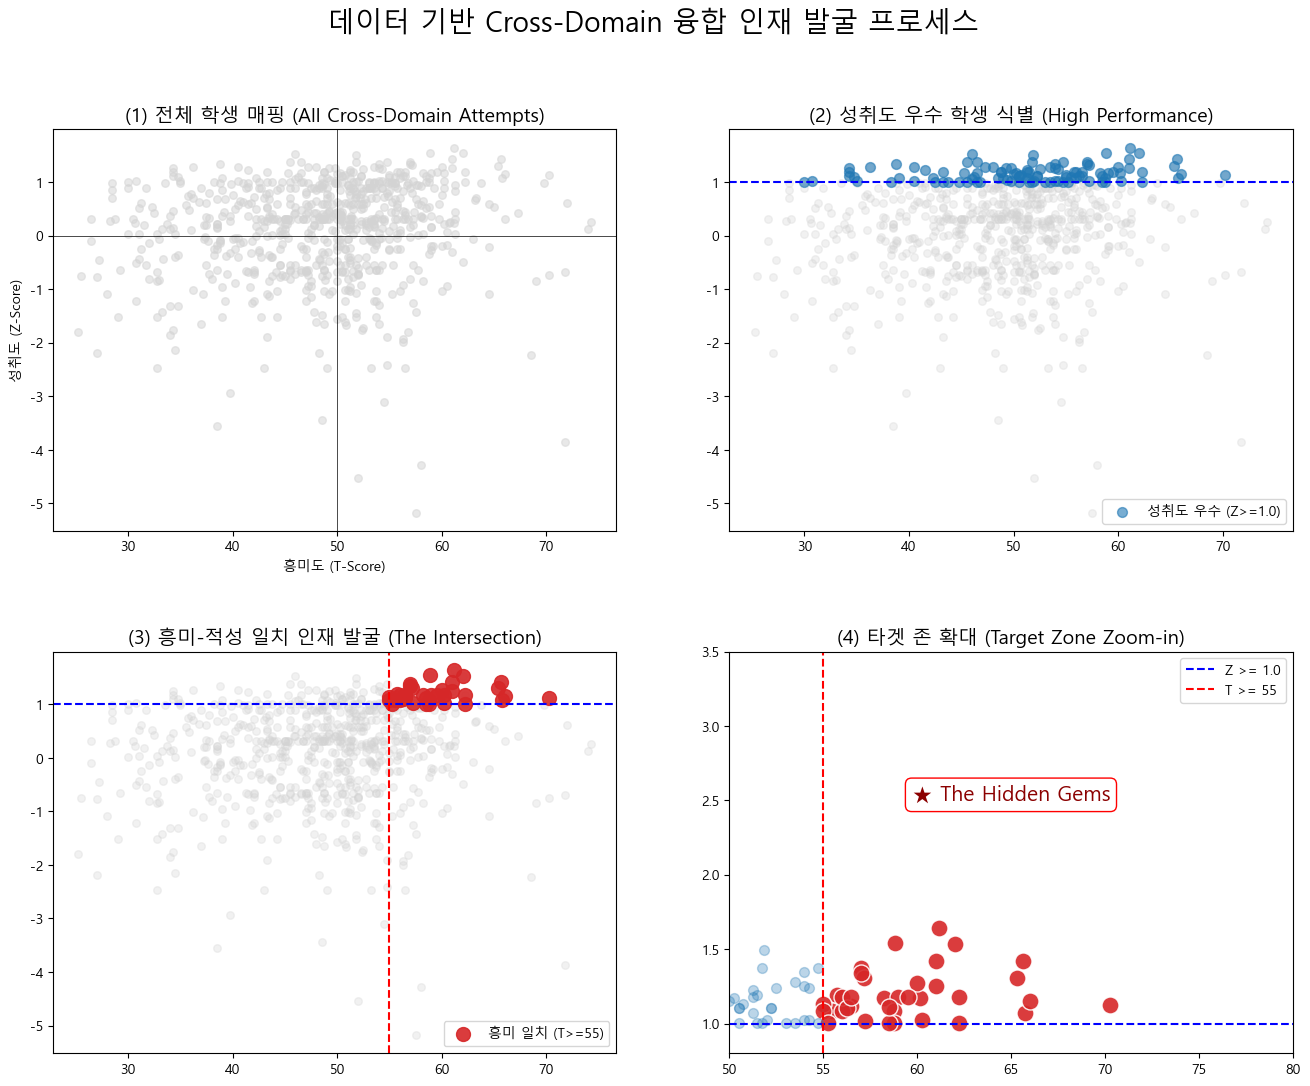

In [ ]:
'''
[Step-by-Step Visualization for Convergence Talent Discovery]

This script generates 4 plots to visualize the filtering process:
1. All Students Mapping: Shows the entire population of cross-domain attempts.
2. High Performers: Highlights students with Z-Score >= 1.0.
3. Interest Match: Highlights high performers who also have High Interest (T-Score >= 55).
4. Target Zoom: Zooms into the 1st quadrant to show the final selected talents.
'''

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic' 
plt.rcParams['axes.unicode_minus'] = False

# =============================================================================
# 1. Data Processing (Re-running to ensure variables exist)
# =============================================================================
# (Assuming previous processing code is correct, I will condense it here for execution)
# Load Data
course_list_df = pd.read_excel('교양교과목록_최종.xlsx')
course_history_df = pd.read_excel('교양교과_수강정보_최종.xlsx')
strong_df = pd.read_excel('STRONG_최종.xlsx')

# Course Tagging
manual_mapping = {'맛있는중국,멋있는중국': 'A', '에디톨로지인간의삶': 'I', '한끼의권리': 'S', '적성이이끄는삶': 'I', '정의란무엇인가': 'I', '삶과드라마': 'A', '여가': 'A'}
strong_keywords_code = {
    'R': ['골프', '축구', '풋살', '스킨스쿠버', '태권도', '탁구', '테니스', '댄스', '호신술', '건강', '재해', '안전', '환경', '생태', '자동차', '드론', '메이커', '3D', '기계', '스포츠', '신체', '농업', '배드민턴', '농생명', '탄소', '에너지', '우주', '지구', '한옥', '군사', '안보', '전투', '지휘', '야전'],
    'I': ['4차산업', 'AI', '인공지능', '데이터', '통계', '수학', '뇌과학', '역사', '철학', '사상', '비판적사고', '인문', '지역학', '과학', '탐구', '논리', '물리', '화학', '생물', '이해', '소프트웨어', 'SW', '코딩', '컴퓨팅', '컴퓨터', '알고리즘', 'ChatGPT', '개발자', '고전', '인간', '지성', '공존', '인구', '유전', '한의학', '한국사', '지리학', '세계대전', '사고와'],
    'A': ['디자인', '미술', '음악', '영화', '연극', '사진', '글쓰기', '문학', '스토리', '한국어', '영어', '중국어', '일본어', '회화', '예술', '창작', '언어', '표현', '드로잉', '영상', '문화', '한자', '오페라', '한문', '잉글리시', 'English', '콘텐츠', '시나리오', '서사', '패션', '와인', '작문'],
    'S': ['봉사', '멘토링', '인권', '복지', '나눔', '심리', '교육', '코칭', '부모', '기독교', '채플', '행복', '성경', '상담', 'AHA', '보살핌', '웰빙', '갈등', '치유', '놀이'],
    'E': ['창업', '스타트업', '경영', '마케팅', '기획', '리더십', '법', '토론', '스피치', '발표', '협상', '권력', '비즈니스', '경제', 'CEO', '리더', '진로', '행정', '범죄', '직무', '커리어', '기업', 'NCS', '취업', '프리젠테이션', '화술', '정치'],
    'C': ['엑셀', 'PPT', '문서', '회계', '세무', '재테크', '투자', '금융', '자산', '실무', '컴퓨터활용', '정보', '스마트', '부동산', '원가', '보고서', '파워포인트', '신용', '채권', '보험']
}
def classify_course_code(course_name):
    if pd.isna(course_name): return 'Unclassified'
    course_str = str(course_name).replace(" ", "")
    if course_name in manual_mapping: return manual_mapping[course_name]
    for code, keywords in strong_keywords_code.items():
        for keyword in keywords:
            if keyword in course_str: return code
    return 'Unclassified'
course_list_df['Course_Type'] = course_list_df['교과목명'].apply(classify_course_code)

# STRONG Clean
new_columns = list(strong_df.columns)
bis_names = strong_df.iloc[1, 7:37].tolist()
for i, name in enumerate(bis_names): new_columns[7 + i] = name
strong_clean = strong_df.iloc[2:].copy()
strong_clean.columns = new_columns
strong_clean = strong_clean.reset_index(drop=True)
target_cols = ['학번', '학부(과)', 'GOT 흥미유형'] + bis_names
strong_user = strong_clean[target_cols].copy()

def extract_got_codes_list(val):
    if pd.isna(val): return []
    codes = []
    parts = str(val).split(',')
    for part in parts:
        part = part.strip()
        if '(' in part: code = part.split('(')[1].replace(')', '')
        else: code = part[0]
        codes.append(code)
    return codes
strong_user['GOT_List'] = strong_user['GOT 흥미유형'].apply(extract_got_codes_list)
strong_user['GOT_Main'] = strong_user['GOT_List'].apply(lambda x: x[0] if len(x) > 0 else np.nan)

# Dept DNA
dept_dna = strong_user.groupby('학부(과)')['GOT_Main'].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan).reset_index()
dept_dna.columns = ['학부(과)', 'Dept_Dominant_Type']
strong_user = pd.merge(strong_user, dept_dna, on='학부(과)', how='left')

# Z-Score
history_merged = pd.merge(course_history_df, course_list_df[['교과목명', 'Course_Type']], left_on='과목명', right_on='교과목명', how='left')
history_valid = history_merged[(history_merged['Course_Type'] != 'Unclassified') & (pd.to_numeric(history_merged['취득점수'], errors='coerce').notnull())].copy()
history_valid['취득점수'] = history_valid['취득점수'].astype(float)
course_stats = history_valid.groupby('과목명')['취득점수'].agg(['mean', 'std']).reset_index()
history_valid = pd.merge(history_valid, course_stats, on='과목명', how='left')
history_valid['z_score'] = (history_valid['취득점수'] - history_valid['mean']) / history_valid['std']
history_valid['z_score'] = history_valid['z_score'].fillna(0)
student_course_perf = history_valid.groupby(['학번', 'Course_Type'])['z_score'].mean().unstack(fill_value=-999).reset_index()

# Merge
master_df = pd.merge(strong_user, student_course_perf, on='학번', how='inner')
bis_map = {
    'R': ['기계/건설', '컴퓨터/전자기기', '군사활동', '안전서비스', '자연/농업', '운동경기'],
    'I': ['과학', '연구조사', '의학', '수학'],
    'A': ['시각예술', '공연예술', '글쓰기/언론', '요리'],
    'S': ['상담/봉사', '교육', '인적 자원개발', '사회봉사', '종교/영성', '보건의료'],
    'E': ['마케팅/광고', '판매', '관리', '기업운영', '정치/대중연설', '법'],
    'C': ['사무관리', '세무/회계', '정보시스템', '금융/투자']
}
for code, cols in bis_map.items():
    valid_cols = [c for c in cols if c in strong_user.columns]
    if valid_cols:
        for c in valid_cols: master_df[c] = pd.to_numeric(master_df[c], errors='coerce')
        master_df[f'Interest_{code}'] = master_df[valid_cols].mean(axis=1)

# =============================================================================
# 2. Visualization Data Prep (Layered Approach)
# =============================================================================
plot_data = []
types = ['R', 'I', 'A', 'S', 'E', 'C']

for idx, row in master_df.iterrows():
    dept_type = row['Dept_Dominant_Type']
    got_list = row['GOT_List']
    
    for talent_type in types:
        # [핵심 로직] 학과 유형과 분석 대상 유형이 같으면 -> 데이터에 넣지 않음!
        if talent_type == dept_type: continue # Cross-domain only
        
        if talent_type in student_course_perf.columns:
            z_val = row[talent_type]
            interest_val = row.get(f'Interest_{talent_type}', 0)
            
            if z_val != -999: # Valid data point
                # Determine category for coloring
                category = '1. 일반 (General)'
                color = 'lightgrey'
                alpha = 0.3
                size = 30
                
                is_high_perf = z_val >= 1.0
                is_high_interest = interest_val >= 55
                
                if is_high_perf and is_high_interest:
                    category = '3. 타겟 (Target)'
                    color = '#d62728' # Red
                    alpha = 0.9
                    size = 100
                elif is_high_perf:
                    category = '2. 성취우수 (High Perf)'
                    color = '#1f77b4' # Blue
                    alpha = 0.6
                    size = 50
                
                plot_data.append({
                    'Interest': interest_val,
                    'Performance': z_val,
                    'Category': category,
                    'Color': color,
                    'Alpha': alpha,
                    'Size': size
                })

viz_df = pd.DataFrame(plot_data)

# =============================================================================
# 3. Generate 4-Step Plots
# =============================================================================
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
plt.subplots_adjust(hspace=0.3, wspace=0.2)

# Plot 1: All Students Mapping
ax1 = axes[0, 0]
ax1.scatter(viz_df['Interest'], viz_df['Performance'], c='lightgrey', alpha=0.5, s=30)
ax1.set_title('(1) 전체 학생 매핑 (All Cross-Domain Attempts)', fontsize=14)
ax1.set_xlabel('흥미도 (T-Score)')
ax1.set_ylabel('성취도 (Z-Score)')
ax1.axhline(0, color='black', linewidth=0.5)
ax1.axvline(50, color='black', linewidth=0.5)

# Plot 2: High Performers Highlight
ax2 = axes[0, 1]
# Base
ax2.scatter(viz_df['Interest'], viz_df['Performance'], c='lightgrey', alpha=0.3, s=30)
# High Perf
high_perf = viz_df[viz_df['Performance'] >= 1.0]
ax2.scatter(high_perf['Interest'], high_perf['Performance'], c='#1f77b4', alpha=0.6, s=50, label='성취도 우수 (Z>=1.0)')
ax2.set_title('(2) 성취도 우수 학생 식별 (High Performance)', fontsize=14)
ax2.axhline(1.0, color='blue', linestyle='--')
ax2.legend(loc='lower right')

# Plot 3: Target Highlight (Match Interest)
ax3 = axes[1, 0]
# Base
ax3.scatter(viz_df['Interest'], viz_df['Performance'], c='lightgrey', alpha=0.3, s=30)
# Target
target = viz_df[viz_df['Category'] == '3. 타겟 (Target)']
ax3.scatter(target['Interest'], target['Performance'], c='#d62728', alpha=0.9, s=100, label='흥미 일치 (T>=55)')
ax3.set_title('(3) 흥미-적성 일치 인재 발굴 (The Intersection)', fontsize=14)
ax3.axhline(1.0, color='blue', linestyle='--')
ax3.axvline(55, color='red', linestyle='--')
ax3.legend(loc='lower right')

# Plot 4: Zoom-in (The Target Zone)
ax4 = axes[1, 1]
# Draw Target points
ax4.scatter(target['Interest'], target['Performance'], c='#d62728', alpha=0.9, s=150, edgecolor='white')
# Draw High Perf (background context)
high_perf_context = viz_df[(viz_df['Performance'] >= 1.0) & (viz_df['Interest'] < 55)]
ax4.scatter(high_perf_context['Interest'], high_perf_context['Performance'], c='#1f77b4', alpha=0.3, s=50)

ax4.set_xlim(50, 80) # Zoom X
ax4.set_ylim(0.8, 3.5) # Zoom Y
ax4.set_title('(4) 타겟 존 확대 (Target Zone Zoom-in)', fontsize=14)
ax4.axhline(1.0, color='blue', linestyle='--', label='Z >= 1.0')
ax4.axvline(55, color='red', linestyle='--', label='T >= 55')
ax4.text(65, 2.5, '★ The Hidden Gems', fontsize=15, color='darkred', ha='center', 
         bbox=dict(facecolor='white', edgecolor='red', boxstyle='round'))
ax4.legend()

plt.suptitle('데이터 기반 Cross-Domain 융합 인재 발굴 프로세스', fontsize=20)
plt.show()

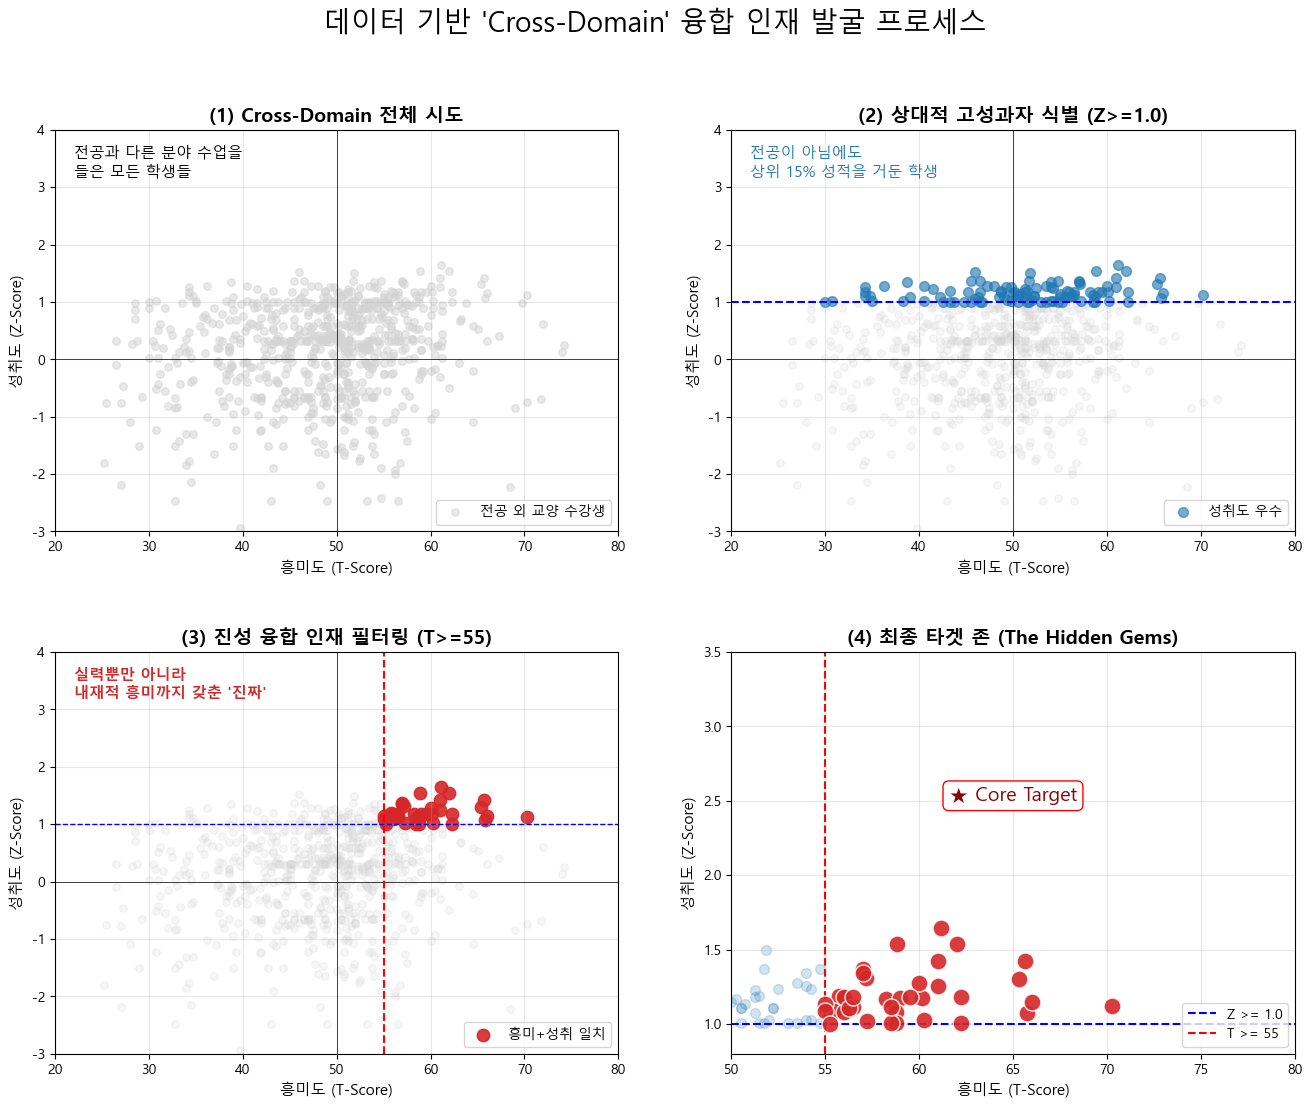

In [5]:
'''
[최종 시각화 코드: 융합 인재 발굴 4단계 파이프라인]

* 핵심: 모든 데이터 포인트는 '전공과 다른 유형(Cross-Domain)'의 수강 이력입니다.
* 구성:
  1. 전체 매핑: 전공 밖으로 나간 모든 시도 (All Attempts)
  2. 성취도 우수: 그 중에서 잘한 학생 (High Performance)
  3. 흥미 일치: 그 중에서 진짜 좋아하는 학생 (Interest Match) -> 진정한 융합
  4. 타겟 확대: 최종 발굴된 인재들의 위치 (Zoom-in)
'''

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic' 
plt.rcParams['axes.unicode_minus'] = False

# =============================================================================
# 1. 데이터 준비 (Cross-Domain 필터링 적용)
# =============================================================================
# (이전 단계에서 master_df, student_course_perf 등이 이미 생성되었다고 가정)
# 시각화용 데이터프레임(viz_df)을 다시 생성하여 로직을 확인합니다.

plot_data = []
types = ['R', 'I', 'A', 'S', 'E', 'C']

for idx, row in master_df.iterrows():
    dept_type = row['Dept_Dominant_Type'] # 학과 유형
    got_list = row['GOT_List']            # 학생 흥미 리스트
    
    for talent_type in types:
        # [Logic 1] 학과 유형과 동일하면 제외 (Cross-Domain Only)
        if talent_type == dept_type: continue 
        
        if talent_type in student_course_perf.columns:
            z_val = row[talent_type]
            interest_val = row.get(f'Interest_{talent_type}', 0)
            
            if z_val != -999:
                # 카테고리 정의 (시각화 색상 구분용)
                category = '1. 일반 시도' # 기본값
                
                # 성취도 우수 (Z >= 1.0)
                if z_val >= 1.0:
                    category = '2. 성취 우수'
                    
                    # 흥미까지 일치 (T >= 55) -> 진정한 융합 인재
                    if interest_val >= 55:
                        category = '3. 융합 인재 (Target)'
                
                plot_data.append({
                    'Interest': interest_val,
                    'Performance': z_val,
                    'Category': category
                })

viz_df = pd.DataFrame(plot_data)

# =============================================================================
# 2. 4단계 시각화 그리기
# =============================================================================
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
plt.subplots_adjust(hspace=0.3, wspace=0.2)

# 공통 설정 함수
def set_plot_style(ax, title):
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('흥미도 (T-Score)', fontsize=11)
    ax.set_ylabel('성취도 (Z-Score)', fontsize=11)
    ax.axhline(0, color='black', linewidth=0.5)
    ax.axvline(50, color='black', linewidth=0.5)
    ax.set_xlim(20, 80)
    ax.set_ylim(-3, 4)
    ax.grid(True, alpha=0.3)

# --- Plot 1: 전체 매핑 (All Cross-Domain Attempts) ---
ax1 = axes[0, 0]
set_plot_style(ax1, '(1) Cross-Domain 전체 시도')
# 모든 점을 회색으로 표시
ax1.scatter(viz_df['Interest'], viz_df['Performance'], c='lightgrey', alpha=0.5, s=30, label='전공 외 교양 수강생')
ax1.legend(loc='lower right')
ax1.text(22, 3.2, "전공과 다른 분야 수업을\n들은 모든 학생들", fontsize=11)


# --- Plot 2: 성취도 우수자 (High Performance) ---
ax2 = axes[0, 1]
set_plot_style(ax2, '(2) 상대적 고성과자 식별 (Z>=1.0)')
# 배경 (회색)
ax2.scatter(viz_df['Interest'], viz_df['Performance'], c='lightgrey', alpha=0.2, s=30)
# 강조 (파란색): 성적이 좋은 학생
high_perf = viz_df[viz_df['Performance'] >= 1.0]
ax2.scatter(high_perf['Interest'], high_perf['Performance'], c='#1f77b4', alpha=0.6, s=50, label='성취도 우수')
ax2.axhline(1.0, color='blue', linestyle='--', linewidth=1.5) # 기준선
ax2.legend(loc='lower right')
ax2.text(22, 3.2, "전공이 아님에도\n상위 15% 성적을 거둔 학생", fontsize=11, color='#1f77b4')


# --- Plot 3: 흥미 일치자 (Interest Match) - 여기가 사용자 질문의 핵심! ---
ax3 = axes[1, 0]
set_plot_style(ax3, '(3) 진성 융합 인재 필터링 (T>=55)')
# 배경
ax3.scatter(viz_df['Interest'], viz_df['Performance'], c='lightgrey', alpha=0.2, s=30)
# 강조 (빨간색): 성적 + 흥미 모두 높은 학생
target = viz_df[viz_df['Category'] == '3. 융합 인재 (Target)']
ax3.scatter(target['Interest'], target['Performance'], c='#d62728', alpha=0.9, s=80, label='흥미+성취 일치')
ax3.axhline(1.0, color='blue', linestyle='--', linewidth=1)
ax3.axvline(55, color='red', linestyle='--', linewidth=1.5) # 기준선
ax3.legend(loc='lower right')
ax3.text(22, 3.2, "실력뿐만 아니라\n내재적 흥미까지 갖춘 '진짜'", fontsize=11, color='#d62728', fontweight='bold')


# --- Plot 4: 타겟 확대 (Target Zoom-in) ---
ax4 = axes[1, 1]
set_plot_style(ax4, '(4) 최종 타겟 존 (The Hidden Gems)')
# 타겟만 확대해서 표시
ax4.scatter(target['Interest'], target['Performance'], c='#d62728', alpha=0.9, s=150, edgecolor='white', zorder=10)
# 주변 맥락 (성취만 좋은 학생들)
high_perf_context = viz_df[(viz_df['Performance'] >= 1.0) & (viz_df['Interest'] < 55)]
ax4.scatter(high_perf_context['Interest'], high_perf_context['Performance'], c='#1f77b4', alpha=0.2, s=50)

ax4.set_xlim(50, 80) # 1사분면 확대
ax4.set_ylim(0.8, 3.5)
ax4.axhline(1.0, color='blue', linestyle='--', label='Z >= 1.0')
ax4.axvline(55, color='red', linestyle='--', label='T >= 55')
ax4.text(65, 2.5, '★ Core Target', fontsize=14, color='darkred', ha='center', 
         bbox=dict(facecolor='white', edgecolor='red', boxstyle='round'))
ax4.legend(loc='lower right')

plt.suptitle("데이터 기반 'Cross-Domain' 융합 인재 발굴 프로세스", fontsize=20)
plt.show()

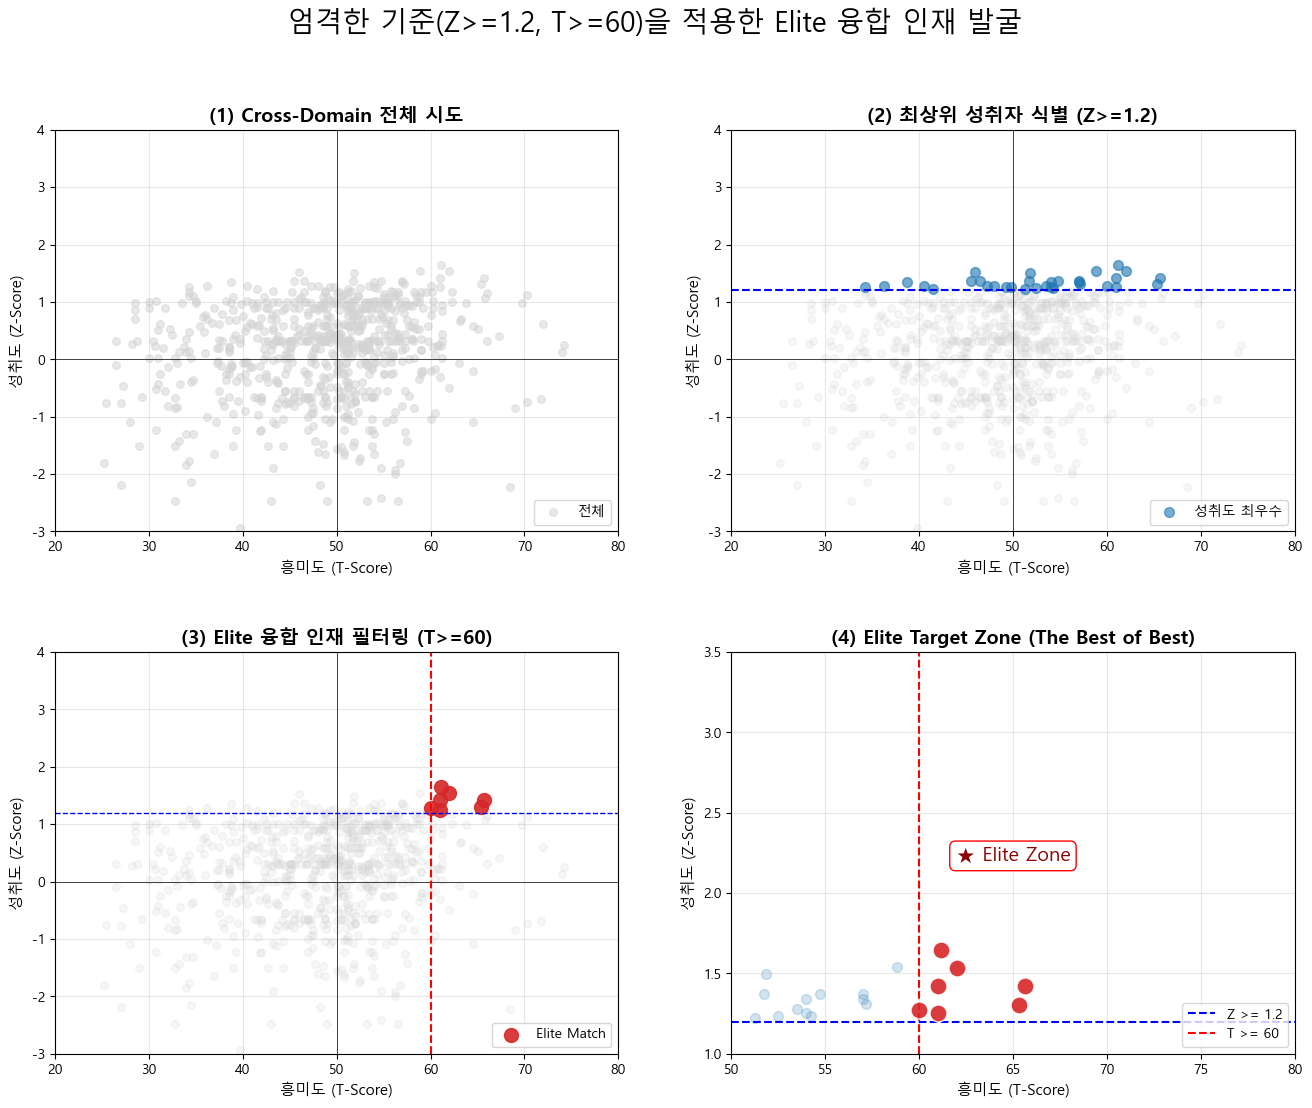


 [Final Report] 기준 상향 조정 결과 (Z>=1.2, T>=60)
       학번        학과    전공유형    발굴유형            융합성격  성취도(Z)  흥미도
05462F6C3   중등특수교육과 S (사회형) E (진취형) 숨겨진 재능 (Hidden)    1.64 61.2
0547EF1AD 웹툰만화콘텐츠학과 A (예술형) R (현장형) 숨겨진 재능 (Hidden)    1.54 62.0
05471CFED     기계공학과 R (현장형) E (진취형) 숨겨진 재능 (Hidden)    1.42 65.7
0547F1BDE    물류무역학과 A (예술형) I (탐구형) 숨겨진 재능 (Hidden)    1.42 61.0
0546CCAD3     국어교육과 S (사회형) E (진취형) 숨겨진 재능 (Hidden)    1.30 65.3
0547ED7B3    인공지능학과 R (현장형) A (예술형)  진로 전환형 (Pivot)    1.28 60.0
0547F0985    물류무역학과 A (예술형) I (탐구형) 숨겨진 재능 (Hidden)    1.25 61.0

>>> 총 7명의 Elite 융합 인재가 발굴되었습니다.


In [6]:
'''
[Refined Analysis with Stricter Thresholds]

Criteria Update:
- Interest (T-Score): >= 60 (Originally 55) -> "High Interest" (Top ~16%)
- Performance (Z-Score): >= 1.2 (Originally 1.0) -> "Superior Performance" (Top ~11.5%)

This script re-evaluates the student pool with these heightened standards to identify "Elite Convergence Talents".
'''

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Font settings
plt.rcParams['font.family'] = 'Malgun Gothic' 
plt.rcParams['axes.unicode_minus'] = False

# =============================================================================
# 1. Data Loading & Processing (Same as before)
# =============================================================================
course_list_df = pd.read_excel('교양교과목록_최종.xlsx')
course_history_df = pd.read_excel('교양교과_수강정보_최종.xlsx')
strong_df = pd.read_excel('STRONG_최종.xlsx')

# Course Tagging
manual_mapping = {'맛있는중국,멋있는중국': 'A', '에디톨로지인간의삶': 'I', '한끼의권리': 'S', '적성이이끄는삶': 'I', '정의란무엇인가': 'I', '삶과드라마': 'A', '여가': 'A'}
strong_keywords_code = {
    'R': ['골프', '축구', '풋살', '스킨스쿠버', '태권도', '탁구', '테니스', '댄스', '호신술', '건강', '재해', '안전', '환경', '생태', '자동차', '드론', '메이커', '3D', '기계', '스포츠', '신체', '농업', '배드민턴', '농생명', '탄소', '에너지', '우주', '지구', '한옥', '군사', '안보', '전투', '지휘', '야전'],
    'I': ['4차산업', 'AI', '인공지능', '데이터', '통계', '수학', '뇌과학', '역사', '철학', '사상', '비판적사고', '인문', '지역학', '과학', '탐구', '논리', '물리', '화학', '생물', '이해', '소프트웨어', 'SW', '코딩', '컴퓨팅', '컴퓨터', '알고리즘', 'ChatGPT', '개발자', '고전', '인간', '지성', '공존', '인구', '유전', '한의학', '한국사', '지리학', '세계대전', '사고와'],
    'A': ['디자인', '미술', '음악', '영화', '연극', '사진', '글쓰기', '문학', '스토리', '한국어', '영어', '중국어', '일본어', '회화', '예술', '창작', '언어', '표현', '드로잉', '영상', '문화', '한자', '오페라', '한문', '잉글리시', 'English', '콘텐츠', '시나리오', '서사', '패션', '와인', '작문'],
    'S': ['봉사', '멘토링', '인권', '복지', '나눔', '심리', '교육', '코칭', '부모', '기독교', '채플', '행복', '성경', '상담', 'AHA', '보살핌', '웰빙', '갈등', '치유', '놀이'],
    'E': ['창업', '스타트업', '경영', '마케팅', '기획', '리더십', '법', '토론', '스피치', '발표', '협상', '권력', '비즈니스', '경제', 'CEO', '리더', '진로', '행정', '범죄', '직무', '커리어', '기업', 'NCS', '취업', '프리젠테이션', '화술', '정치'],
    'C': ['엑셀', 'PPT', '문서', '회계', '세무', '재테크', '투자', '금융', '자산', '실무', '컴퓨터활용', '정보', '스마트', '부동산', '원가', '보고서', '파워포인트', '신용', '채권', '보험']
}
def classify_course_code(course_name):
    if pd.isna(course_name): return 'Unclassified'
    course_str = str(course_name).replace(" ", "")
    if course_name in manual_mapping: return manual_mapping[course_name]
    for code, keywords in strong_keywords_code.items():
        for keyword in keywords:
            if keyword in course_str: return code
    return 'Unclassified'
course_list_df['Course_Type'] = course_list_df['교과목명'].apply(classify_course_code)

# STRONG Clean & Dept DNA
new_columns = list(strong_df.columns)
bis_names = strong_df.iloc[1, 7:37].tolist()
for i, name in enumerate(bis_names): new_columns[7 + i] = name
strong_clean = strong_df.iloc[2:].copy()
strong_clean.columns = new_columns
strong_clean = strong_clean.reset_index(drop=True)
target_cols = ['학번', '학부(과)', 'GOT 흥미유형'] + bis_names
strong_user = strong_clean[target_cols].copy()

def extract_got_codes_list(val):
    if pd.isna(val): return []
    codes = []
    parts = str(val).split(',')
    for part in parts:
        part = part.strip()
        if '(' in part: code = part.split('(')[1].replace(')', '')
        else: code = part[0]
        codes.append(code)
    return codes
strong_user['GOT_List'] = strong_user['GOT 흥미유형'].apply(extract_got_codes_list)
strong_user['GOT_Main'] = strong_user['GOT_List'].apply(lambda x: x[0] if len(x) > 0 else np.nan)

dept_dna = strong_user.groupby('학부(과)')['GOT_Main'].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan).reset_index()
dept_dna.columns = ['학부(과)', 'Dept_Dominant_Type']
strong_user = pd.merge(strong_user, dept_dna, on='학부(과)', how='left')

# Z-Score
history_merged = pd.merge(course_history_df, course_list_df[['교과목명', 'Course_Type']], left_on='과목명', right_on='교과목명', how='left')
history_valid = history_merged[(history_merged['Course_Type'] != 'Unclassified') & (pd.to_numeric(history_merged['취득점수'], errors='coerce').notnull())].copy()
history_valid['취득점수'] = history_valid['취득점수'].astype(float)
course_stats = history_valid.groupby('과목명')['취득점수'].agg(['mean', 'std']).reset_index()
history_valid = pd.merge(history_valid, course_stats, on='과목명', how='left')
history_valid['z_score'] = (history_valid['취득점수'] - history_valid['mean']) / history_valid['std']
history_valid['z_score'] = history_valid['z_score'].fillna(0)
student_course_perf = history_valid.groupby(['학번', 'Course_Type'])['z_score'].mean().unstack(fill_value=-999).reset_index()

# Merge
master_df = pd.merge(strong_user, student_course_perf, on='학번', how='inner')
bis_map = {
    'R': ['기계/건설', '컴퓨터/전자기기', '군사활동', '안전서비스', '자연/농업', '운동경기'],
    'I': ['과학', '연구조사', '의학', '수학'],
    'A': ['시각예술', '공연예술', '글쓰기/언론', '요리'],
    'S': ['상담/봉사', '교육', '인적 자원개발', '사회봉사', '종교/영성', '보건의료'],
    'E': ['마케팅/광고', '판매', '관리', '기업운영', '정치/대중연설', '법'],
    'C': ['사무관리', '세무/회계', '정보시스템', '금융/투자']
}
for code, cols in bis_map.items():
    valid_cols = [c for c in cols if c in strong_user.columns]
    if valid_cols:
        for c in valid_cols: master_df[c] = pd.to_numeric(master_df[c], errors='coerce')
        master_df[f'Interest_{code}'] = master_df[valid_cols].mean(axis=1)

# =============================================================================
# 2. Stricter Filtering (Visualization Data Prep)
# =============================================================================
# New Thresholds
TARGET_Z = 1.2
TARGET_T = 60

plot_data = []
types = ['R', 'I', 'A', 'S', 'E', 'C']
type_names = {'R': 'R (현장형)', 'I': 'I (탐구형)', 'A': 'A (예술형)', 'S': 'S (사회형)', 'E': 'E (진취형)', 'C': 'C (사무형)'}

selected_data_points = []

for idx, row in master_df.iterrows():
    dept_type = row['Dept_Dominant_Type']
    got_list = row['GOT_List']
    
    for talent_type in types:
        if talent_type == dept_type: continue # Cross-domain check
        
        if talent_type in student_course_perf.columns:
            z_val = row[talent_type]
            interest_val = row.get(f'Interest_{talent_type}', 0)
            
            if z_val != -999:
                category = '1. 일반 시도'
                
                # Determine Category based on new thresholds
                if z_val >= TARGET_Z:
                    if interest_val >= TARGET_T:
                        category = '3. 융합 인재 (Elite Target)'
                        
                        # Detailed info for result table
                        fusion_category = ""
                        if talent_type in got_list:
                            rank = got_list.index(talent_type) + 1
                            fusion_category = "진로 전환형 (Pivot)" if rank == 1 else "역량 확장형 (Expansion)"
                        else:
                            fusion_category = "숨겨진 재능 (Hidden)"
                        
                        selected_data_points.append({
                            '학번': row['학번'],
                            '학과': row['학부(과)'],
                            '전공유형': type_names.get(dept_type, dept_type),
                            '발굴유형': type_names.get(talent_type, talent_type),
                            '융합성격': fusion_category,
                            '성취도(Z)': round(z_val, 2),
                            '흥미도': round(interest_val, 1)
                        })
                        
                    else:
                        category = '2. 성취 우수'
                
                plot_data.append({
                    'Interest': interest_val,
                    'Performance': z_val,
                    'Category': category
                })

viz_df = pd.DataFrame(plot_data)
result_df = pd.DataFrame(selected_data_points)

# =============================================================================
# 3. Generate Plots with New Standards
# =============================================================================
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
plt.subplots_adjust(hspace=0.3, wspace=0.2)

def set_plot_style(ax, title):
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('흥미도 (T-Score)', fontsize=11)
    ax.set_ylabel('성취도 (Z-Score)', fontsize=11)
    ax.axhline(0, color='black', linewidth=0.5)
    ax.axvline(50, color='black', linewidth=0.5)
    ax.set_xlim(20, 80)
    ax.set_ylim(-3, 4)
    ax.grid(True, alpha=0.3)

# Plot 1: All
ax1 = axes[0, 0]
set_plot_style(ax1, '(1) Cross-Domain 전체 시도')
ax1.scatter(viz_df['Interest'], viz_df['Performance'], c='lightgrey', alpha=0.5, s=30, label='전체')
ax1.legend(loc='lower right')

# Plot 2: High Perf
ax2 = axes[0, 1]
set_plot_style(ax2, f'(2) 최상위 성취자 식별 (Z>={TARGET_Z})')
ax2.scatter(viz_df['Interest'], viz_df['Performance'], c='lightgrey', alpha=0.2, s=30)
high_perf = viz_df[viz_df['Performance'] >= TARGET_Z]
ax2.scatter(high_perf['Interest'], high_perf['Performance'], c='#1f77b4', alpha=0.6, s=50, label='성취도 최우수')
ax2.axhline(TARGET_Z, color='blue', linestyle='--', linewidth=1.5)
ax2.legend(loc='lower right')

# Plot 3: Elite Target
ax3 = axes[1, 0]
set_plot_style(ax3, f'(3) Elite 융합 인재 필터링 (T>={TARGET_T})')
ax3.scatter(viz_df['Interest'], viz_df['Performance'], c='lightgrey', alpha=0.2, s=30)
target = viz_df[viz_df['Category'] == '3. 융합 인재 (Elite Target)']
ax3.scatter(target['Interest'], target['Performance'], c='#d62728', alpha=0.9, s=100, label='Elite Match')
ax3.axhline(TARGET_Z, color='blue', linestyle='--', linewidth=1)
ax3.axvline(TARGET_T, color='red', linestyle='--', linewidth=1.5)
ax3.legend(loc='lower right')

# Plot 4: Zoom-in
ax4 = axes[1, 1]
set_plot_style(ax4, '(4) Elite Target Zone (The Best of Best)')
ax4.scatter(target['Interest'], target['Performance'], c='#d62728', alpha=0.9, s=150, edgecolor='white', zorder=10)
high_perf_context = viz_df[(viz_df['Performance'] >= TARGET_Z) & (viz_df['Interest'] < TARGET_T)]
ax4.scatter(high_perf_context['Interest'], high_perf_context['Performance'], c='#1f77b4', alpha=0.2, s=50)
ax4.set_xlim(50, 80)
ax4.set_ylim(TARGET_Z - 0.2, 3.5)
ax4.axhline(TARGET_Z, color='blue', linestyle='--', label=f'Z >= {TARGET_Z}')
ax4.axvline(TARGET_T, color='red', linestyle='--', label=f'T >= {TARGET_T}')
ax4.text(65, TARGET_Z + 1.0, '★ Elite Zone', fontsize=14, color='darkred', ha='center', 
         bbox=dict(facecolor='white', edgecolor='red', boxstyle='round'))
ax4.legend(loc='lower right')

plt.suptitle("엄격한 기준(Z>=1.2, T>=60)을 적용한 Elite 융합 인재 발굴", fontsize=20)
plt.show()

# List Output
print("\n" + "="*80)
print(f" [Final Report] 기준 상향 조정 결과 (Z>={TARGET_Z}, T>={TARGET_T})")
print("="*80)
if not result_df.empty:
    display_cols = ['학번', '학과', '전공유형', '발굴유형', '융합성격', '성취도(Z)', '흥미도']
    print(result_df[display_cols].sort_values(by=['성취도(Z)', '흥미도'], ascending=False).head(15).to_string(index=False))
    print(f"\n>>> 총 {len(result_df)}명의 Elite 융합 인재가 발굴되었습니다.")
else:
    print("해당 기준을 만족하는 인재가 없습니다. 기준을 조금 완화해보세요.")

C:\Users\brigh\AppData\Local\Temp\ipykernel_11688\3978648708.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette=clrs)
C:\Users\brigh\AppData\Local\Temp\ipykernel_11688\3978648708.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette=clrs)
C:\Users\brigh\AppData\Local\Temp\ipykernel_11688\3978648708.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette=clrs)
C:\Users\brigh\AppData\Local\Temp\ipykernel_11688\3978648708.py:

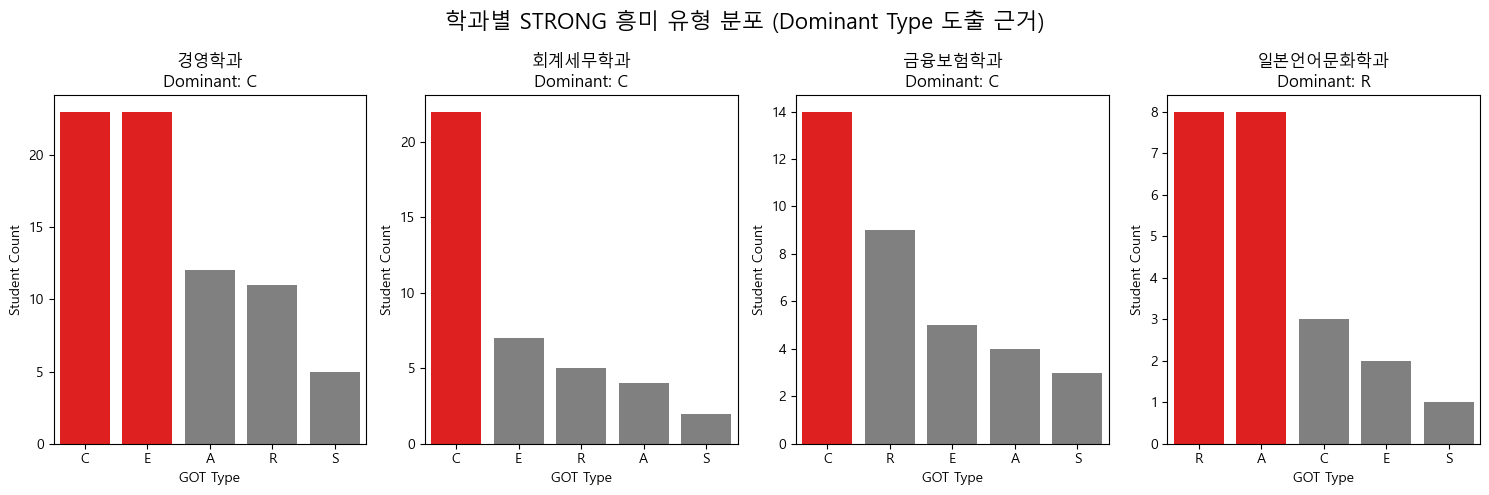


=== [Transparency] Z-Score 산출 과정 예시 (Top 10 성취도) ===
       과목명        학번  취득점수      mean       std  z_score
   게이미피케이션 0543A7C23  97.0 89.285714  3.099096 2.489205
      JJ한자 0547EEED5  98.0 73.254902 10.478250 2.361568
 뮤지컬레퍼토리실습 05459909F 100.0 90.235294  4.146224 2.355084
  예술의이해와체험 054742CD3 100.0 80.258145  8.963972 2.202356
 와인과전통주바이블 05450CEDF  98.0 74.187500 10.920713 2.180490
      JJ한자 0546AC29C  96.0 73.254902 10.478250 2.170696
창의적문제해결방법론 0544AB801  99.0 88.000000  5.086747 2.162482
  경제의개념과활용 0546DDB94 100.0 81.525773  8.636101 2.139186
  예술의이해와체험 054617840  99.0 80.258145  8.963972 2.090798
  예술의이해와체험 0546B313E  99.0 80.258145  8.963972 2.090798


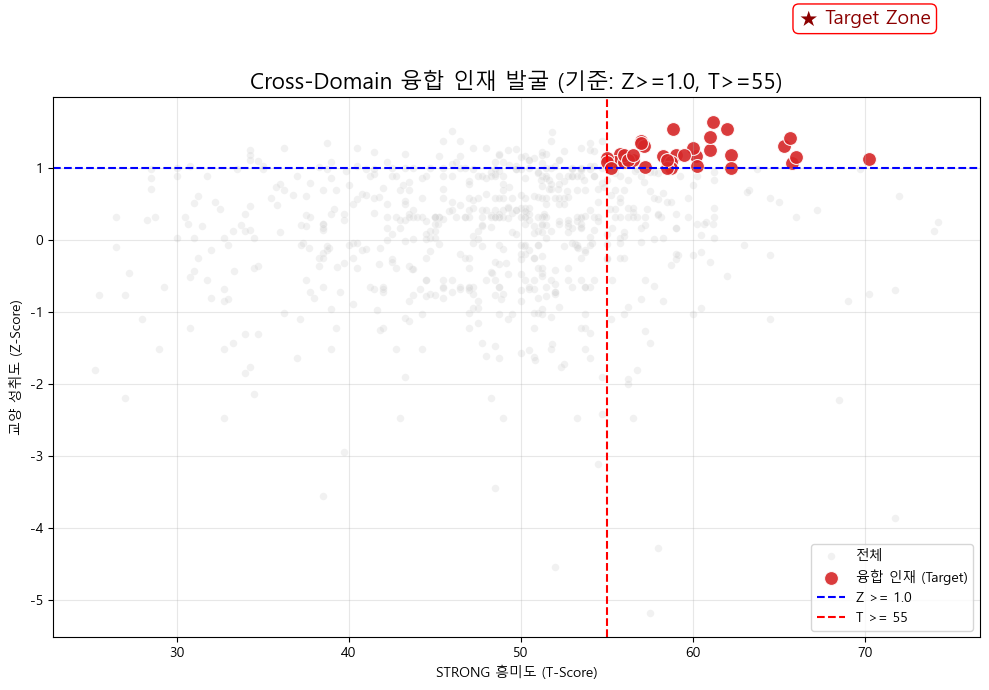


 [Final Report] 최종 발굴된 융합 인재 리스트 (기준: Z>=1.0, T>=55)
       학번        학과    전공유형    발굴유형            융합성격  성취도(Z)  흥미도
05462F6C3   중등특수교육과 S (사회형) E (진취형) 숨겨진 재능 (Hidden)    1.64 61.2
0547EF1AD 웹툰만화콘텐츠학과 A (예술형) R (현장형) 숨겨진 재능 (Hidden)    1.54 62.0
05449F8E6    한국어문학과 A (예술형) R (현장형) 숨겨진 재능 (Hidden)    1.54 58.8
05471CFED     기계공학과 R (현장형) E (진취형) 숨겨진 재능 (Hidden)    1.42 65.7
0547F1BDE    물류무역학과 A (예술형) I (탐구형) 숨겨진 재능 (Hidden)    1.42 61.0
0547EE065      경영학과 C (사무형) A (예술형)  진로 전환형 (Pivot)    1.37 57.0
0547EF02C      경영학과 C (사무형) A (예술형) 숨겨진 재능 (Hidden)    1.34 57.0
0547EE17D  일본언어문화학과 A (예술형) R (현장형)  진로 전환형 (Pivot)    1.31 57.2
0546CCAD3     국어교육과 S (사회형) E (진취형) 숨겨진 재능 (Hidden)    1.30 65.3
0547ED7B3    인공지능학과 R (현장형) A (예술형)  진로 전환형 (Pivot)    1.28 60.0
0547F0985    물류무역학과 A (예술형) I (탐구형) 숨겨진 재능 (Hidden)    1.25 61.0
0547EDADF 웹툰만화콘텐츠학과 A (예술형) I (탐구형) 숨겨진 재능 (Hidden)    1.19 55.8
0547F0F89    운동처방학과 R (현장형) A (예술형)  진로 전환형 (Pivot)    1.18 62.2
0547EF844      경영학과 C (사무형) A (예술형) 

In [11]:
'''
[Final Analysis & Visualization Code]

Content:
1. Revert to Original Criteria: Z >= 1.0, T >= 55
2. Z-Score Logic Transparency: Display sample calculation table
3. Dept DNA Logic Transparency: Visualize GOT distribution per department
4. Final 4-Quadrant Scatter Plot
5. Final Talent List
'''

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Font Settings
plt.rcParams['font.family'] = 'Malgun Gothic' 
plt.rcParams['axes.unicode_minus'] = False

# =============================================================================
# 1. Data Loading & Processing
# =============================================================================
course_list_df = pd.read_excel('교양교과목록_최종.xlsx')
course_history_df = pd.read_excel('교양교과_수강정보_최종.xlsx')
strong_df = pd.read_excel('STRONG_최종.xlsx')

# Course Tagging
manual_mapping = {'맛있는중국,멋있는중국': 'A', '에디톨로지인간의삶': 'I', '한끼의권리': 'S', '적성이이끄는삶': 'I', '정의란무엇인가': 'I', '삶과드라마': 'A', '여가': 'A'}
strong_keywords_code = {
    'R': ['골프', '축구', '풋살', '스킨스쿠버', '태권도', '탁구', '테니스', '댄스', '호신술', '건강', '재해', '안전', '환경', '생태', '자동차', '드론', '메이커', '3D', '기계', '스포츠', '신체', '농업', '배드민턴', '농생명', '탄소', '에너지', '우주', '지구', '한옥', '군사', '안보', '전투', '지휘', '야전'],
    'I': ['4차산업', 'AI', '인공지능', '데이터', '통계', '수학', '뇌과학', '역사', '철학', '사상', '비판적사고', '인문', '지역학', '과학', '탐구', '논리', '물리', '화학', '생물', '이해', '소프트웨어', 'SW', '코딩', '컴퓨팅', '컴퓨터', '알고리즘', 'ChatGPT', '개발자', '고전', '인간', '지성', '공존', '인구', '유전', '한의학', '한국사', '지리학', '세계대전', '사고와'],
    'A': ['디자인', '미술', '음악', '영화', '연극', '사진', '글쓰기', '문학', '스토리', '한국어', '영어', '중국어', '일본어', '회화', '예술', '창작', '언어', '표현', '드로잉', '영상', '문화', '한자', '오페라', '한문', '잉글리시', 'English', '콘텐츠', '시나리오', '서사', '패션', '와인', '작문'],
    'S': ['봉사', '멘토링', '인권', '복지', '나눔', '심리', '교육', '코칭', '부모', '기독교', '채플', '행복', '성경', '상담', 'AHA', '보살핌', '웰빙', '갈등', '치유', '놀이'],
    'E': ['창업', '스타트업', '경영', '마케팅', '기획', '리더십', '법', '토론', '스피치', '발표', '협상', '권력', '비즈니스', '경제', 'CEO', '리더', '진로', '행정', '범죄', '직무', '커리어', '기업', 'NCS', '취업', '프리젠테이션', '화술', '정치'],
    'C': ['엑셀', 'PPT', '문서', '회계', '세무', '재테크', '투자', '금융', '자산', '실무', '컴퓨터활용', '정보', '스마트', '부동산', '원가', '보고서', '파워포인트', '신용', '채권', '보험']
}
def classify_course_code(course_name):
    if pd.isna(course_name): return 'Unclassified'
    course_str = str(course_name).replace(" ", "")
    if course_name in manual_mapping: return manual_mapping[course_name]
    for code, keywords in strong_keywords_code.items():
        for keyword in keywords:
            if keyword in course_str: return code
    return 'Unclassified'
course_list_df['Course_Type'] = course_list_df['교과목명'].apply(classify_course_code)

# STRONG Data
new_columns = list(strong_df.columns)
bis_names = strong_df.iloc[1, 7:37].tolist()
for i, name in enumerate(bis_names): new_columns[7 + i] = name
strong_clean = strong_df.iloc[2:].copy()
strong_clean.columns = new_columns
strong_clean = strong_clean.reset_index(drop=True)
target_cols = ['학번', '학부(과)', 'GOT 흥미유형'] + bis_names
strong_user = strong_clean[target_cols].copy()

def extract_got_codes_list(val):
    if pd.isna(val): return []
    codes = []
    parts = str(val).split(',')
    for part in parts:
        part = part.strip()
        if '(' in part: code = part.split('(')[1].replace(')', '')
        else: code = part[0]
        codes.append(code)
    return codes
strong_user['GOT_List'] = strong_user['GOT 흥미유형'].apply(extract_got_codes_list)
strong_user['GOT_Main'] = strong_user['GOT_List'].apply(lambda x: x[0] if len(x) > 0 else np.nan)

# -----------------------------------------------------------------------------
# 2. [Visualization] Department DNA Classification Logic
# -----------------------------------------------------------------------------
# Visualize distribution for sample departments
sample_depts = strong_user['학부(과)'].value_counts().head(4).index.tolist()
if '기계공학과' not in sample_depts: sample_depts.append('기계공학과') # Make sure we include our example

plt.figure(figsize=(15, 5))
for i, dept in enumerate(sample_depts[:4]): # Top 4 only
    plt.subplot(1, 4, i+1)
    dept_data = strong_user[strong_user['학부(과)'] == dept]
    counts = dept_data['GOT_Main'].value_counts()
    
    # Determine colors (highlight max)
    clrs = ['grey' if (x < max(counts.values)) else 'red' for x in counts.values]
    
    sns.barplot(x=counts.index, y=counts.values, palette=clrs)
    plt.title(f'{dept}\nDominant: {counts.idxmax()}', fontsize=12)
    plt.ylabel('Student Count')
    plt.xlabel('GOT Type')

plt.suptitle("학과별 STRONG 흥미 유형 분포 (Dominant Type 도출 근거)", fontsize=16)
plt.tight_layout()
plt.show()

# Apply Dept DNA
dept_dna = strong_user.groupby('학부(과)')['GOT_Main'].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan).reset_index()
dept_dna.columns = ['학부(과)', 'Dept_Dominant_Type']
strong_user = pd.merge(strong_user, dept_dna, on='학부(과)', how='left')

# -----------------------------------------------------------------------------
# 3. [Metric Calculation] Z-Score Logic Transparency
# -----------------------------------------------------------------------------
history_merged = pd.merge(course_history_df, course_list_df[['교과목명', 'Course_Type']], left_on='과목명', right_on='교과목명', how='left')
history_valid = history_merged[(history_merged['Course_Type'] != 'Unclassified') & (pd.to_numeric(history_merged['취득점수'], errors='coerce').notnull())].copy()
history_valid['취득점수'] = history_valid['취득점수'].astype(float)

# Calculate Stats
course_stats = history_valid.groupby('과목명')['취득점수'].agg(['mean', 'std']).reset_index()
history_valid = pd.merge(history_valid, course_stats, on='과목명', how='left')
history_valid['z_score'] = (history_valid['취득점수'] - history_valid['mean']) / history_valid['std']
history_valid['z_score'] = history_valid['z_score'].fillna(0)

# *** Show Z-Score Calculation Sample ***
sample_z = history_valid[['과목명', '학번', '취득점수', 'mean', 'std', 'z_score']].sort_values(by='z_score', ascending=False).head(10)
print("\n=== [Transparency] Z-Score 산출 과정 예시 (Top 10 성취도) ===")
print(sample_z.to_string(index=False))

# Student Perf Pivot
student_course_perf = history_valid.groupby(['학번', 'Course_Type'])['z_score'].mean().unstack(fill_value=-999).reset_index()

# -----------------------------------------------------------------------------
# 4. [Filtering] Talent Discovery (Original Criteria: Z>=1.0, T>=55)
# -----------------------------------------------------------------------------
# Merge Data
master_df = pd.merge(strong_user, student_course_perf, on='학번', how='inner')
bis_map = {
    'R': ['기계/건설', '컴퓨터/전자기기', '군사활동', '안전서비스', '자연/농업', '운동경기'],
    'I': ['과학', '연구조사', '의학', '수학'],
    'A': ['시각예술', '공연예술', '글쓰기/언론', '요리'],
    'S': ['상담/봉사', '교육', '인적 자원개발', '사회봉사', '종교/영성', '보건의료'],
    'E': ['마케팅/광고', '판매', '관리', '기업운영', '정치/대중연설', '법'],
    'C': ['사무관리', '세무/회계', '정보시스템', '금융/투자']
}
for code, cols in bis_map.items():
    valid_cols = [c for c in cols if c in strong_user.columns]
    if valid_cols:
        for c in valid_cols: master_df[c] = pd.to_numeric(master_df[c], errors='coerce')
        master_df[f'Interest_{code}'] = master_df[valid_cols].mean(axis=1)

# Filtering
TARGET_Z = 1.0
TARGET_T = 55

plot_data = []
selected_data_points = []
types = ['R', 'I', 'A', 'S', 'E', 'C']
type_names = {'R': 'R (현장형)', 'I': 'I (탐구형)', 'A': 'A (예술형)', 'S': 'S (사회형)', 'E': 'E (진취형)', 'C': 'C (사무형)'}

for idx, row in master_df.iterrows():
    dept_type = row['Dept_Dominant_Type']
    got_list = row['GOT_List']
    
    for talent_type in types:
        if talent_type == dept_type: continue
        
        if talent_type in student_course_perf.columns:
            z_val = row[talent_type]
            interest_val = row.get(f'Interest_{talent_type}', 0)
            
            if z_val != -999:
                category = '1. 일반'
                if z_val >= TARGET_Z:
                    if interest_val >= TARGET_T:
                        category = '3. 타겟'
                        
                        fusion_category = ""
                        if talent_type in got_list:
                            rank = got_list.index(talent_type) + 1
                            fusion_category = "진로 전환형 (Pivot)" if rank == 1 else "역량 확장형 (Expansion)"
                        else:
                            fusion_category = "숨겨진 재능 (Hidden)"
                        
                        selected_data_points.append({
                            '학번': row['학번'],
                            '학과': row['학부(과)'],
                            '전공유형': type_names.get(dept_type, dept_type),
                            '발굴유형': type_names.get(talent_type, talent_type),
                            '융합성격': fusion_category,
                            '성취도(Z)': round(z_val, 2),
                            '흥미도': round(interest_val, 1)
                        })
                    else:
                        category = '2. 성취우수'
                
                plot_data.append({'Interest': interest_val, 'Performance': z_val, 'Category': category})

viz_df = pd.DataFrame(plot_data)
result_df = pd.DataFrame(selected_data_points)

# -----------------------------------------------------------------------------
# 5. [Visualization] Final 4-Quadrant Plot
# -----------------------------------------------------------------------------
plt.figure(figsize=(10, 7))

# 1. Base
sns.scatterplot(data=viz_df, x='Interest', y='Performance', c='lightgrey', alpha=0.3, s=30, label='전체')

# 2. Target
target = viz_df[viz_df['Category'] == '3. 타겟']
if not target.empty:
    sns.scatterplot(data=target, x='Interest', y='Performance', c='#d62728', alpha=0.9, s=100, label='융합 인재 (Target)')

# 3. Lines & Text
plt.axhline(TARGET_Z, color='blue', linestyle='--', label=f'Z >= {TARGET_Z}')
plt.axvline(TARGET_T, color='red', linestyle='--', label=f'T >= {TARGET_T}')
plt.text(70, 3.0, '★ Target Zone', fontsize=14, color='darkred', ha='center', 
         bbox=dict(facecolor='white', edgecolor='red', boxstyle='round'))

plt.title(f"Cross-Domain 융합 인재 발굴 (기준: Z>={TARGET_Z}, T>={TARGET_T})", fontsize=16)
plt.xlabel('STRONG 흥미도 (T-Score)')
plt.ylabel('교양 성취도 (Z-Score)')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# 6. [Output] Final List
# -----------------------------------------------------------------------------
print("\n" + "="*90)
print(f" [Final Report] 최종 발굴된 융합 인재 리스트 (기준: Z>={TARGET_Z}, T>={TARGET_T})")
print("="*90)
if not result_df.empty:
    display_cols = ['학번', '학과', '전공유형', '발굴유형', '융합성격', '성취도(Z)', '흥미도']
    print(result_df[display_cols].sort_values(by=['성취도(Z)', '흥미도'], ascending=False).to_string(index=False))
    print(f"\n>>> 총 {len(result_df)}명의 융합 인재가 발굴되었습니다.")
else:
    print("조건을 만족하는 인재가 없습니다.")

In [18]:

sample_z.to_string(index=False)
sample_z

,과목명,학번,취득점수,mean,std,z_score
5623,게이미피케이션,0543A7C23,97.0,89.285714,3.099096,2.489205
97709,JJ한자,0547EEED5,98.0,73.254902,10.478250,2.361568
63978,뮤지컬레퍼토리실습,05459909F,100.0,90.235294,4.146224,2.355084
97078,예술의이해와체험,054742CD3,100.0,80.258145,8.963972,2.202356
91760,와인과전통주바이블,05450CEDF,98.0,74.187500,10.920713,2.180490
100423,JJ한자,0546AC29C,96.0,73.254902,10.478250,2.170696
15008,창의적문제해결방법론,0544AB801,99.0,88.000000,5.086747,2.162482
58058,경제의개념과활용,0546DDB94,100.0,81.525773,8.636101,2.139186
47531,예술의이해와체험,054617840,99.0,80.258145,8.963972,2.090798
72701,예술의이해와체험,0546B313E,99.0,80.258145,8.963972,2.090798


In [19]:
import pandas as pd
import numpy as np

# (데이터 로드는 이전과 동일하다고 가정)
# strong_user 데이터프레임 사용

# ---------------------------------------------------------
# [개선된 로직] 학과 DNA 산출 (동률 처리 포함)
# ---------------------------------------------------------
def get_dept_mode(series):
    if series.empty: return np.nan
    
    modes = series.mode()
    
    # 공동 1등이 없는 경우 (단일 유형)
    if len(modes) == 1:
        return modes[0]
    
    # 공동 1등이 있는 경우 (복합 유형)
    else:
        # 예: 'A'와 'R'이 동률이면 -> "A/R"로 반환
        return "/".join(sorted(modes))

# 학과별 유형 다시 산출
dept_dna_refined = strong_user.groupby('학부(과)')['GOT_Main'].agg(get_dept_mode).reset_index()
dept_dna_refined.columns = ['학부(과)', 'Dept_Dominant_Type']

# ---------------------------------------------------------
# 동률 발생 학과 확인
# ---------------------------------------------------------
tie_depts = dept_dna_refined[dept_dna_refined['Dept_Dominant_Type'].str.contains('/', na=False)]

print(f"=== 동률(Tie) 발생 학과 수: {len(tie_depts)}개 ===")
if not tie_depts.empty:
    print(tie_depts)
else:
    print("다행히 모든 학과가 단일 유형으로 명확히 구분되었습니다.")

# 전체 학과 유형 분포 확인
print("\n=== 학과 유형 분포 (Top 5) ===")
print(dept_dna_refined['Dept_Dominant_Type'].value_counts())

=== 동률(Tie) 발생 학과 수: 13개 ===
       학부(과) Dept_Dominant_Type
0     IT금융학과                C/S
2      건축공학과                C/S
5       경영학과                C/E
7     관광경영학과              E/I/S
13    물류무역학과              A/C/E
14  반려동물산업학과                A/I
24    식품영양학과                R/S
25  신소재화학공학과                I/S
37  일본언어문화학과                A/R
40      재활학과                R/S
41   정보통신공학과              A/E/R
49      행정학과                A/C
51   환경생명과학과                A/C

=== 학과 유형 분포 (Top 5) ===
Dept_Dominant_Type
R        14
S        10
A        10
C         3
C/S       2
A/C       2
R/S       2
I         2
A/C/E     1
E/I/S     1
C/E       1
A/I       1
I/S       1
A/R       1
A/E/R     1
E         1
Name: count, dtype: int64


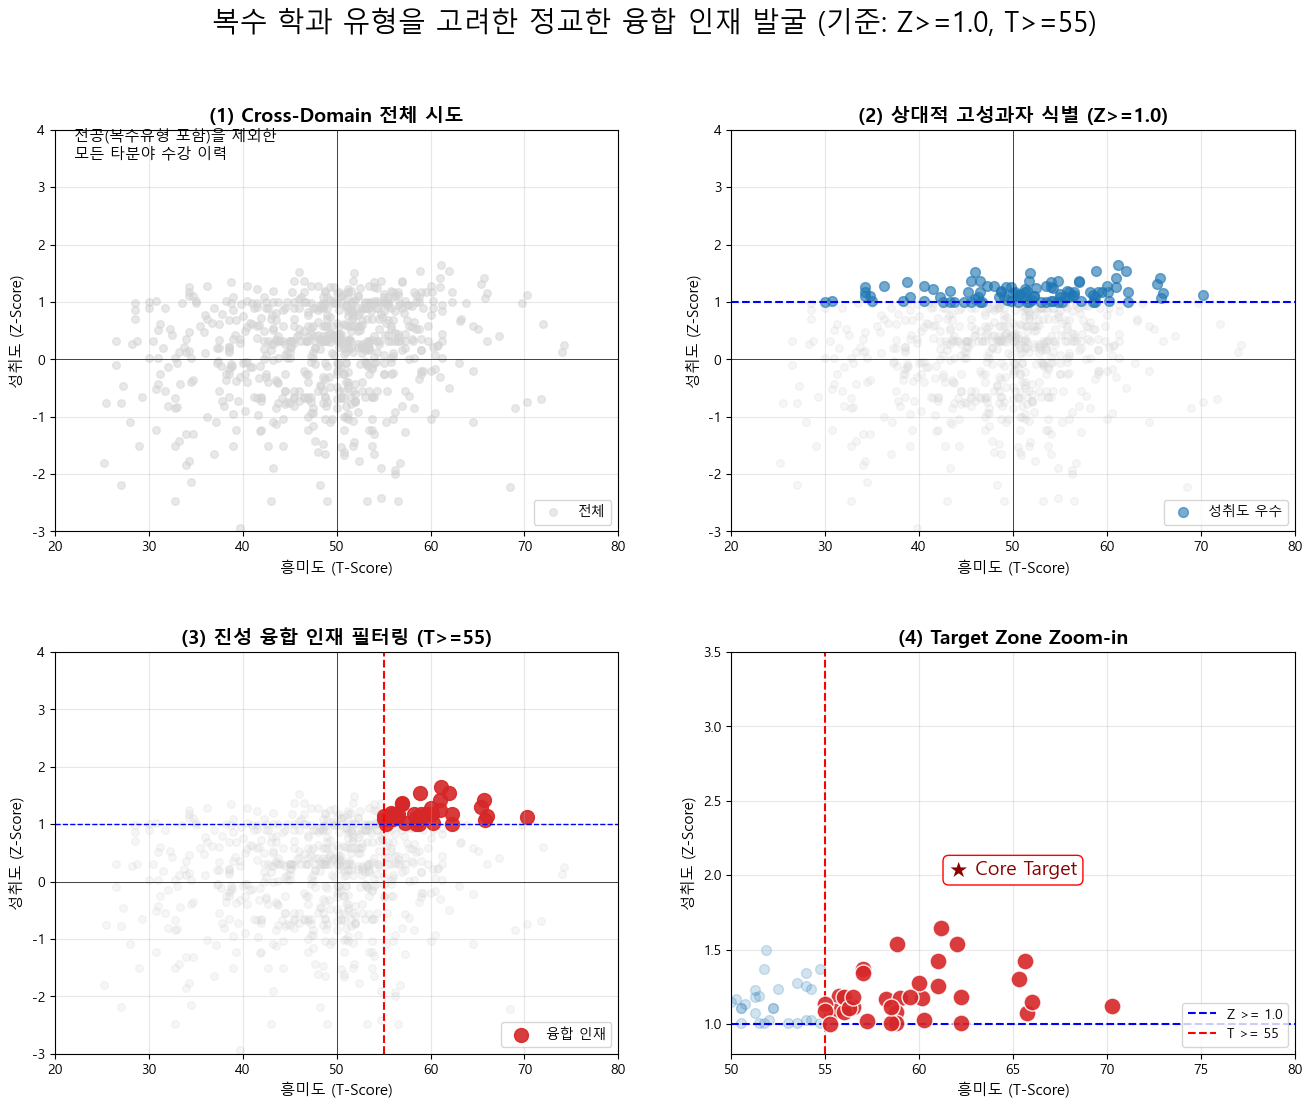


 [Final Report] 복수 유형 학과 고려 결과 (Z>=1.0, T>=55)
       학번        학과  전공유형    발굴유형                융합성격  성취도(Z)  흥미도
05462F6C3   중등특수교육과     S E (진취형) 히든 챔피언 (Specialist)    1.64 61.2
0547EF1AD 웹툰만화콘텐츠학과     A R (현장형) 히든 챔피언 (Specialist)    1.54 62.0
05449F8E6    한국어문학과     A R (현장형) 히든 챔피언 (Specialist)    1.54 58.8
05471CFED     기계공학과     R E (진취형) 히든 챔피언 (Specialist)    1.42 65.7
0547F1BDE    물류무역학과 A/C/E I (탐구형) 히든 챔피언 (Specialist)    1.42 61.0
0547EE065      경영학과   C/E A (예술형) 진로 개척형 (Challenger)    1.37 57.0
0547EF02C      경영학과   C/E A (예술형) 히든 챔피언 (Specialist)    1.34 57.0
0546CCAD3     국어교육과     S E (진취형) 히든 챔피언 (Specialist)    1.30 65.3
0547ED7B3    인공지능학과     R A (예술형) 진로 개척형 (Challenger)    1.28 60.0
0547F0985    물류무역학과 A/C/E I (탐구형) 히든 챔피언 (Specialist)    1.25 61.0
0547EDADF 웹툰만화콘텐츠학과     A I (탐구형) 히든 챔피언 (Specialist)    1.19 55.8
0547F0F89    운동처방학과     R A (예술형) 진로 개척형 (Challenger)    1.18 62.2
0547EF844      경영학과   C/E A (예술형) 진로 개척형 (Challenger)    1.18 59.5
0547EE71F     

In [20]:
'''
[Final Refined Analysis: Multi-Type Departments & Adjusted Criteria]

Updates:
1. Dept DNA: Handles ties (e.g., "A/R") where multiple types are equally dominant.
2. Convergence Logic: Students in multi-type departments must excel in a field OUTSIDE all of their department's dominant types.
3. Visualization: 4-Step plots with updated logic explanations.
'''

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Font
plt.rcParams['font.family'] = 'Malgun Gothic' 
plt.rcParams['axes.unicode_minus'] = False

# =============================================================================
# 1. Data Loading & Processing
# =============================================================================
course_list_df = pd.read_excel('교양교과목록_최종.xlsx')
course_history_df = pd.read_excel('교양교과_수강정보_최종.xlsx')
strong_df = pd.read_excel('STRONG_최종.xlsx')

# Course Tagging
manual_mapping = {'맛있는중국,멋있는중국': 'A', '에디톨로지인간의삶': 'I', '한끼의권리': 'S', '적성이이끄는삶': 'I', '정의란무엇인가': 'I', '삶과드라마': 'A', '여가': 'A'}
strong_keywords_code = {
    'R': ['골프', '축구', '풋살', '스킨스쿠버', '태권도', '탁구', '테니스', '댄스', '호신술', '건강', '재해', '안전', '환경', '생태', '자동차', '드론', '메이커', '3D', '기계', '스포츠', '신체', '농업', '배드민턴', '농생명', '탄소', '에너지', '우주', '지구', '한옥', '군사', '안보', '전투', '지휘', '야전'],
    'I': ['4차산업', 'AI', '인공지능', '데이터', '통계', '수학', '뇌과학', '역사', '철학', '사상', '비판적사고', '인문', '지역학', '과학', '탐구', '논리', '물리', '화학', '생물', '이해', '소프트웨어', 'SW', '코딩', '컴퓨팅', '컴퓨터', '알고리즘', 'ChatGPT', '개발자', '고전', '인간', '지성', '공존', '인구', '유전', '한의학', '한국사', '지리학', '세계대전', '사고와'],
    'A': ['디자인', '미술', '음악', '영화', '연극', '사진', '글쓰기', '문학', '스토리', '한국어', '영어', '중국어', '일본어', '회화', '예술', '창작', '언어', '표현', '드로잉', '영상', '문화', '한자', '오페라', '한문', '잉글리시', 'English', '콘텐츠', '시나리오', '서사', '패션', '와인', '작문'],
    'S': ['봉사', '멘토링', '인권', '복지', '나눔', '심리', '교육', '코칭', '부모', '기독교', '채플', '행복', '성경', '상담', 'AHA', '보살핌', '웰빙', '갈등', '치유', '놀이'],
    'E': ['창업', '스타트업', '경영', '마케팅', '기획', '리더십', '법', '토론', '스피치', '발표', '협상', '권력', '비즈니스', '경제', 'CEO', '리더', '진로', '행정', '범죄', '직무', '커리어', '기업', 'NCS', '취업', '프리젠테이션', '화술', '정치'],
    'C': ['엑셀', 'PPT', '문서', '회계', '세무', '재테크', '투자', '금융', '자산', '실무', '컴퓨터활용', '정보', '스마트', '부동산', '원가', '보고서', '파워포인트', '신용', '채권', '보험']
}
def classify_course_code(course_name):
    if pd.isna(course_name): return 'Unclassified'
    course_str = str(course_name).replace(" ", "")
    if course_name in manual_mapping: return manual_mapping[course_name]
    for code, keywords in strong_keywords_code.items():
        for keyword in keywords:
            if keyword in course_str: return code
    return 'Unclassified'
course_list_df['Course_Type'] = course_list_df['교과목명'].apply(classify_course_code)

# STRONG Clean
new_columns = list(strong_df.columns)
bis_names = strong_df.iloc[1, 7:37].tolist()
for i, name in enumerate(bis_names): new_columns[7 + i] = name
strong_clean = strong_df.iloc[2:].copy()
strong_clean.columns = new_columns
strong_clean = strong_clean.reset_index(drop=True)
target_cols = ['학번', '학부(과)', 'GOT 흥미유형'] + bis_names
strong_user = strong_clean[target_cols].copy()

def extract_got_codes_list(val):
    if pd.isna(val): return []
    codes = []
    parts = str(val).split(',')
    for part in parts:
        part = part.strip()
        if '(' in part: code = part.split('(')[1].replace(')', '')
        else: code = part[0]
        codes.append(code)
    return codes
strong_user['GOT_List'] = strong_user['GOT 흥미유형'].apply(extract_got_codes_list)
strong_user['GOT_Main'] = strong_user['GOT_List'].apply(lambda x: x[0] if len(x) > 0 else np.nan)

# -----------------------------------------------------------------------------
# [NEW] Dept DNA with Tie Handling
# -----------------------------------------------------------------------------
def get_dept_mode(series):
    if series.empty: return np.nan
    modes = series.mode()
    if len(modes) == 1:
        return modes[0]
    else:
        return "/".join(sorted(modes)) # Return "A/R" format

dept_dna = strong_user.groupby('학부(과)')['GOT_Main'].agg(get_dept_mode).reset_index()
dept_dna.columns = ['학부(과)', 'Dept_Dominant_Type']
strong_user = pd.merge(strong_user, dept_dna, on='학부(과)', how='left')

# Z-Score
history_merged = pd.merge(course_history_df, course_list_df[['교과목명', 'Course_Type']], left_on='과목명', right_on='교과목명', how='left')
history_valid = history_merged[(history_merged['Course_Type'] != 'Unclassified') & (pd.to_numeric(history_merged['취득점수'], errors='coerce').notnull())].copy()
history_valid['취득점수'] = history_valid['취득점수'].astype(float)
course_stats = history_valid.groupby('과목명')['취득점수'].agg(['mean', 'std']).reset_index()
history_valid = pd.merge(history_valid, course_stats, on='과목명', how='left')
history_valid['z_score'] = (history_valid['취득점수'] - history_valid['mean']) / history_valid['std']
history_valid['z_score'] = history_valid['z_score'].fillna(0)
student_course_perf = history_valid.groupby(['학번', 'Course_Type'])['z_score'].mean().unstack(fill_value=-999).reset_index()

# Merge
master_df = pd.merge(strong_user, student_course_perf, on='학번', how='inner')
bis_map = {
    'R': ['기계/건설', '컴퓨터/전자기기', '군사활동', '안전서비스', '자연/농업', '운동경기'],
    'I': ['과학', '연구조사', '의학', '수학'],
    'A': ['시각예술', '공연예술', '글쓰기/언론', '요리'],
    'S': ['상담/봉사', '교육', '인적 자원개발', '사회봉사', '종교/영성', '보건의료'],
    'E': ['마케팅/광고', '판매', '관리', '기업운영', '정치/대중연설', '법'],
    'C': ['사무관리', '세무/회계', '정보시스템', '금융/투자']
}
for code, cols in bis_map.items():
    valid_cols = [c for c in cols if c in strong_user.columns]
    if valid_cols:
        for c in valid_cols: master_df[c] = pd.to_numeric(master_df[c], errors='coerce')
        master_df[f'Interest_{code}'] = master_df[valid_cols].mean(axis=1)

# =============================================================================
# 2. Visualization Data Prep (Original Criteria: Z>=1.0, T>=55)
# =============================================================================
TARGET_Z = 1.0
TARGET_T = 55

plot_data = []
selected_data_points = []
types = ['R', 'I', 'A', 'S', 'E', 'C']
type_names = {'R': 'R (현장형)', 'I': 'I (탐구형)', 'A': 'A (예술형)', 'S': 'S (사회형)', 'E': 'E (진취형)', 'C': 'C (사무형)'}

for idx, row in master_df.iterrows():
    dept_type_str = str(row['Dept_Dominant_Type'])
    dept_types = dept_type_str.split('/') # Handle "A/R" -> ['A', 'R']
    got_list = row['GOT_List']
    
    for talent_type in types:
        # [Updated Logic] Exclude if talent matches ANY dominant type of the department
        if talent_type in dept_types: continue 
        
        if talent_type in student_course_perf.columns:
            z_val = row[talent_type]
            interest_val = row.get(f'Interest_{talent_type}', 0)
            
            if z_val != -999:
                category = '1. 일반'
                if z_val >= TARGET_Z:
                    if interest_val >= TARGET_T:
                        category = '3. 타겟'
                        
                        fusion_category = ""
                        if talent_type in got_list:
                            rank = got_list.index(talent_type) + 1
                            fusion_category = "진로 개척형 (Challenger)" if rank == 1 else "융합 완성형 (Converger)"
                        else:
                            fusion_category = "히든 챔피언 (Specialist)"
                        
                        selected_data_points.append({
                            '학번': row['학번'],
                            '학과': row['학부(과)'],
                            '전공유형': dept_type_str,
                            '발굴유형': type_names.get(talent_type, talent_type),
                            '융합성격': fusion_category,
                            '성취도(Z)': round(z_val, 2),
                            '흥미도': round(interest_val, 1)
                        })
                    else:
                        category = '2. 성취우수'
                
                plot_data.append({'Interest': interest_val, 'Performance': z_val, 'Category': category})

viz_df = pd.DataFrame(plot_data)
result_df = pd.DataFrame(selected_data_points)

# =============================================================================
# 3. 4-Step Visualization
# =============================================================================
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
plt.subplots_adjust(hspace=0.3, wspace=0.2)

def set_plot_style(ax, title):
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('흥미도 (T-Score)', fontsize=11)
    ax.set_ylabel('성취도 (Z-Score)', fontsize=11)
    ax.axhline(0, color='black', linewidth=0.5)
    ax.axvline(50, color='black', linewidth=0.5)
    ax.set_xlim(20, 80)
    ax.set_ylim(-3, 4)
    ax.grid(True, alpha=0.3)

# Plot 1
ax1 = axes[0, 0]
set_plot_style(ax1, '(1) Cross-Domain 전체 시도')
ax1.scatter(viz_df['Interest'], viz_df['Performance'], c='lightgrey', alpha=0.5, s=30, label='전체')
ax1.text(22, 3.5, "전공(복수유형 포함)을 제외한\n모든 타분야 수강 이력", fontsize=11)
ax1.legend(loc='lower right')

# Plot 2
ax2 = axes[0, 1]
set_plot_style(ax2, f'(2) 상대적 고성과자 식별 (Z>={TARGET_Z})')
ax2.scatter(viz_df['Interest'], viz_df['Performance'], c='lightgrey', alpha=0.2, s=30)
high_perf = viz_df[viz_df['Performance'] >= TARGET_Z]
ax2.scatter(high_perf['Interest'], high_perf['Performance'], c='#1f77b4', alpha=0.6, s=50, label='성취도 우수')
ax2.axhline(TARGET_Z, color='blue', linestyle='--', linewidth=1.5)
ax2.legend(loc='lower right')

# Plot 3
ax3 = axes[1, 0]
set_plot_style(ax3, f'(3) 진성 융합 인재 필터링 (T>={TARGET_T})')
ax3.scatter(viz_df['Interest'], viz_df['Performance'], c='lightgrey', alpha=0.2, s=30)
target = viz_df[viz_df['Category'] == '3. 타겟']
ax3.scatter(target['Interest'], target['Performance'], c='#d62728', alpha=0.9, s=100, label='융합 인재')
ax3.axhline(TARGET_Z, color='blue', linestyle='--', linewidth=1)
ax3.axvline(TARGET_T, color='red', linestyle='--', linewidth=1.5)
ax3.legend(loc='lower right')

# Plot 4
ax4 = axes[1, 1]
set_plot_style(ax4, '(4) Target Zone Zoom-in')
ax4.scatter(target['Interest'], target['Performance'], c='#d62728', alpha=0.9, s=150, edgecolor='white', zorder=10)
high_perf_context = viz_df[(viz_df['Performance'] >= TARGET_Z) & (viz_df['Interest'] < TARGET_T)]
ax4.scatter(high_perf_context['Interest'], high_perf_context['Performance'], c='#1f77b4', alpha=0.2, s=50)
ax4.set_xlim(50, 80)
ax4.set_ylim(TARGET_Z - 0.2, 3.5)
ax4.axhline(TARGET_Z, color='blue', linestyle='--', label=f'Z >= {TARGET_Z}')
ax4.axvline(TARGET_T, color='red', linestyle='--', label=f'T >= {TARGET_T}')
ax4.text(65, TARGET_Z + 1.0, '★ Core Target', fontsize=14, color='darkred', ha='center', 
         bbox=dict(facecolor='white', edgecolor='red', boxstyle='round'))
ax4.legend(loc='lower right')

plt.suptitle(f"복수 학과 유형을 고려한 정교한 융합 인재 발굴 (기준: Z>={TARGET_Z}, T>={TARGET_T})", fontsize=20)
plt.show()

# List Output
print("\n" + "="*90)
print(f" [Final Report] 복수 유형 학과 고려 결과 (Z>={TARGET_Z}, T>={TARGET_T})")
print("="*90)
if not result_df.empty:
    display_cols = ['학번', '학과', '전공유형', '발굴유형', '융합성격', '성취도(Z)', '흥미도']
    print(result_df[display_cols].sort_values(by=['성취도(Z)', '흥미도'], ascending=False).to_string(index=False))
    print(f"\n>>> 총 {len(result_df)}명의 융합 인재가 발굴되었습니다.")
else:
    print("조건을 만족하는 인재가 없습니다.")

In [26]:
display_cols = ['학번', '학과', '전공유형', '발굴유형', '성취도(Z)', '흥미도']
result_df[display_cols].sort_values(by=['성취도(Z)', '흥미도'], ascending=False)

,학번,학과,전공유형,발굴유형,성취도(Z),흥미도
1,05462F6C3,중등특수교육과,S,E (진취형),1.64,61.2
17,0547EF1AD,웹툰만화콘텐츠학과,A,R (현장형),1.54,62.0
0,05449F8E6,한국어문학과,A,R (현장형),1.54,58.8
5,05471CFED,기계공학과,R,E (진취형),1.42,65.7
33,0547F1BDE,물류무역학과,A/C/E,I (탐구형),1.42,61.0
12,0547EE065,경영학과,C/E,A (예술형),1.37,57.0
16,0547EF02C,경영학과,C/E,A (예술형),1.34,57.0
2,0546CCAD3,국어교육과,S,E (진취형),1.30,65.3
9,0547ED7B3,인공지능학과,R,A (예술형),1.28,60.0
24,0547F0985,물류무역학과,A/C/E,I (탐구형),1.25,61.0


In [25]:
result_df[display_cols].sort_values(by=['성취도(Z)', '흥미도'], ascending=False)

,학번,학과,전공유형,발굴유형,융합성격,성취도(Z),흥미도
1,05462F6C3,중등특수교육과,S,E (진취형),히든 챔피언 (Specialist),1.64,61.2
17,0547EF1AD,웹툰만화콘텐츠학과,A,R (현장형),히든 챔피언 (Specialist),1.54,62.0
0,05449F8E6,한국어문학과,A,R (현장형),히든 챔피언 (Specialist),1.54,58.8
5,05471CFED,기계공학과,R,E (진취형),히든 챔피언 (Specialist),1.42,65.7
33,0547F1BDE,물류무역학과,A/C/E,I (탐구형),히든 챔피언 (Specialist),1.42,61.0
12,0547EE065,경영학과,C/E,A (예술형),진로 개척형 (Challenger),1.37,57.0
16,0547EF02C,경영학과,C/E,A (예술형),히든 챔피언 (Specialist),1.34,57.0
2,0546CCAD3,국어교육과,S,E (진취형),히든 챔피언 (Specialist),1.30,65.3
9,0547ED7B3,인공지능학과,R,A (예술형),진로 개척형 (Challenger),1.28,60.0
24,0547F0985,물류무역학과,A/C/E,I (탐구형),히든 챔피언 (Specialist),1.25,61.0


C:\Users\brigh\AppData\Local\Temp\ipykernel_11688\2305488128.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette=clrs)
C:\Users\brigh\AppData\Local\Temp\ipykernel_11688\2305488128.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette=clrs)
C:\Users\brigh\AppData\Local\Temp\ipykernel_11688\2305488128.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette=clrs)
C:\Users\brigh\AppData\Local\Temp\ipykernel_11688\2305488128.py:

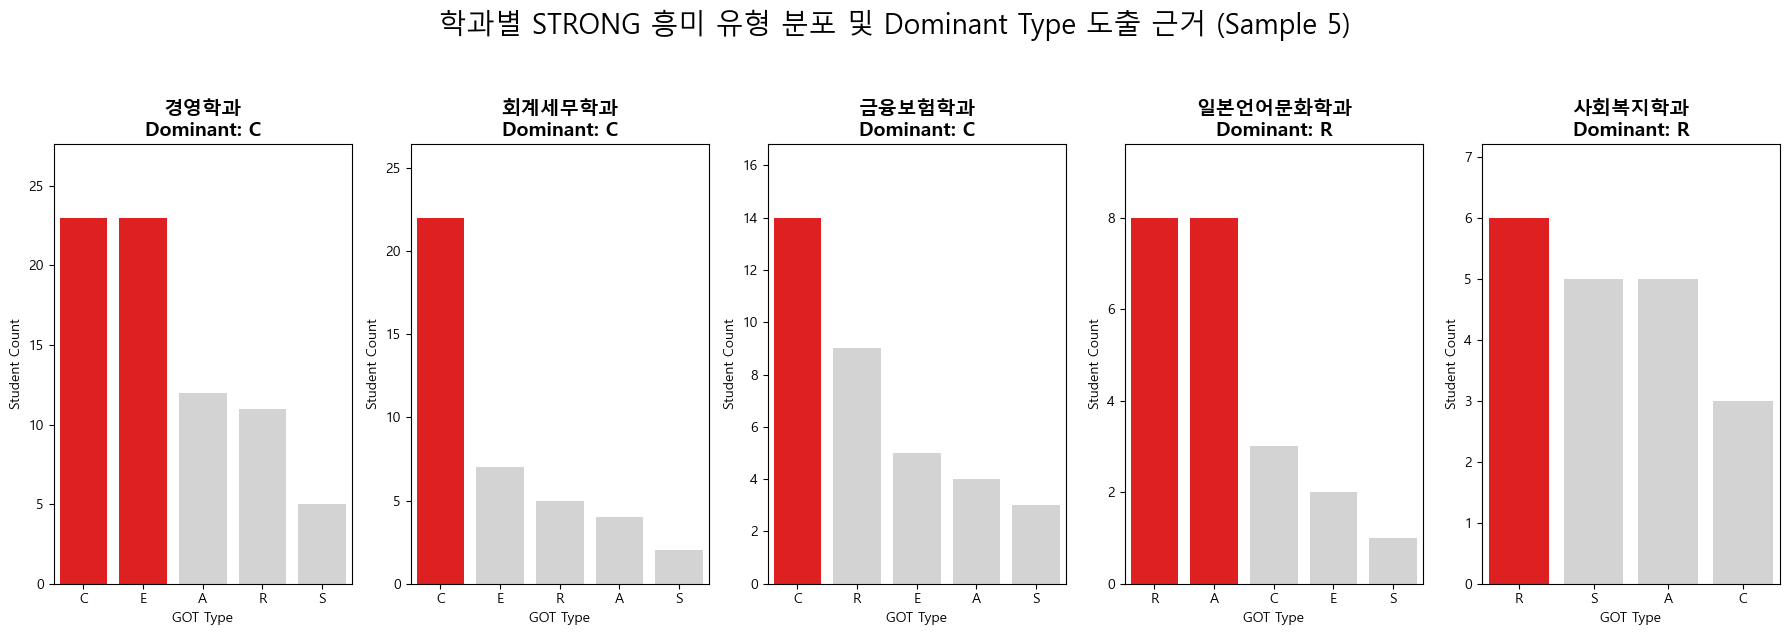

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정 (폰트가 없는 환경을 대비해 영문으로 출력하거나 에러 방지)
plt.rcParams['font.family'] = 'Malgun Gothic' 
plt.rcParams['axes.unicode_minus'] = False

# 1. Load Data
strong_df = pd.read_excel('STRONG_최종.xlsx')

# 2. Preprocess STRONG Data
new_columns = list(strong_df.columns)
bis_names = strong_df.iloc[1, 7:37].tolist()
for i, name in enumerate(bis_names): new_columns[7 + i] = name
strong_clean = strong_df.iloc[2:].copy()
strong_clean.columns = new_columns
strong_clean = strong_clean.reset_index(drop=True)

target_cols = ['학번', '학부(과)', 'GOT 흥미유형']
strong_user = strong_clean[target_cols].copy()

# Extract GOT Code
def extract_got_codes_list(val):
    if pd.isna(val): return []
    codes = []
    parts = str(val).split(',')
    for part in parts:
        part = part.strip()
        if '(' in part: code = part.split('(')[1].replace(')', '')
        else: code = part[0]
        codes.append(code)
    return codes

strong_user['GOT_List'] = strong_user['GOT 흥미유형'].apply(extract_got_codes_list)
strong_user['GOT_Main'] = strong_user['GOT_List'].apply(lambda x: x[0] if len(x) > 0 else np.nan)

# 3. Visualization: Department DNA Classification Logic (5 Sample Depts)
# Select 5 departments with sufficient data for demonstration
top_depts = strong_user['학부(과)'].value_counts().head(10).index.tolist()
# Try to pick a diverse set if possible, or just top 5
sample_depts = top_depts[:5]

plt.figure(figsize=(18, 6)) # Width increased for 5 plots

for i, dept in enumerate(sample_depts):
    plt.subplot(1, 5, i+1) # 1 row, 5 columns
    
    dept_data = strong_user[strong_user['학부(과)'] == dept]
    if dept_data.empty: continue
    
    counts = dept_data['GOT_Main'].value_counts()
    
    if counts.empty: continue
    
    # Highlight the dominant type
    max_val = counts.max()
    clrs = ['red' if x == max_val else 'lightgrey' for x in counts.values]
    
    sns.barplot(x=counts.index, y=counts.values, palette=clrs)
    
    dominant_type = counts.idxmax()
    
    plt.title(f'{dept}\nDominant: {dominant_type}', fontsize=14, fontweight='bold')
    plt.ylabel('Student Count')
    plt.xlabel('GOT Type')
    plt.ylim(0, max_val * 1.2) # Add some headroom

plt.suptitle("학과별 STRONG 흥미 유형 분포 및 Dominant Type 도출 근거 (Sample 5)", fontsize=20, y=1.05)
plt.tight_layout()
plt.show()